**1.   프로그램 상품판매실적 예측 : MAPE**

* 20분마다 각 상품의 실적 예측

* 판매가 0인건 제외 (무형, 보험상품)

* 예측상품중 과거 실적이 없는 경우 유사카테고리 혹은 동일 마더코드로 예측

* 1분 단위 시청률 데이터 제공 


**2.   최적 수익을 고려한 요일별 / 시간대별 / 카테고리별 편성 최적화 방안(모형) 제시**

- 20년 6월1일~30일 프로그램 상품판매실적 예측을 토대로 요일별 / 시간별 / 최적화 편성표 제시.

- 근데 데이터는 19년 1년 치만 있넹


# Colab 연결 및 Import


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os                                            # 디렉토리 설정
os.chdir("/content/gdrive/Shared drives/2020 빅콘테스트")

Mounted at /content/gdrive


In [ ]:
!pip install catboost
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
from dateutil.parser import parse
import requests
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
#from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import math
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import collections
import itertools
import seaborn as sns
import matplotlib.font_manager as fm
import re
from wordcloud import WordCloud
from keras.models import load_model
import pickle
from keras.models import model_from_json

!pip install munkres
from munkres import Munkres, print_matrix
import sys

     |████████████████████████████████| 66.1MB 44kB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_day(x):
    if x == 0 :
        return 'mon'
    elif x == 1 :
        return 'tue'
    elif x == 2 :
        return 'wed'
    elif x == 3 :
        return 'thu'
    elif x == 4 :
        return 'fri'
    elif x == 5 :
        return 'sat'
    else :
        return 'sun'


class holiday2019():
    HOLIDAYS = ((1, 1), #"new Year"
                (2, 4), #"new Year"
                (2, 5), #"new Year1"
                (2, 6), #"new Year2"
                (3, 1), #"3.1"
                (5, 5), #"Children's Day" 일요일
                (5, 6), #"Children's Day 대체휴일"
                (5, 12), #"Buddha Day"
                (6, 6), #"Memorial Day"
                (8, 15), #"Liberation Day"
                (9, 12), #"Thanksgiving"
                (9, 13), #"Thanksgiving1"
                (9, 14), #"Thanksgiving2"
                (10, 3), #"National Foundation Day"
                (10, 9), #"Hangul Day"
                (12, 25) #"Christmas"
                )
 
    def is_holiday(self, daytuple):
        HOLIDAYS = self.HOLIDAYS
        if daytuple in HOLIDAYS:
            return 1
        else:
            return 0
 
def Norm(x):
  stats = x.describe()
  stats = stats.transpose()
  return (x - stats['mean']) / stats['std']


def Charge(x):
  words = ['무이자', '일시불', '(일)', '(무)']
  r = 'None'
  for i in words:
    if i in x:
      r = i
  return r

def Brand(x):
  words = ['LG', '쿠쿠', '보루네오', '삼성', '쿠첸', '푸마', '삼익가구', '피올레', '보몽드', '휘센', '루이띠에' ,'비버리힐스폴로클럽', '제니비', '린나이', '루나', '뱅뱅', '프라다', '품안애', '종근당']
  r = 'None'
  for i in words:
    if i in x:
      r = i
  return r

def Packages(x):
  words = ['패키지','세트']
  for i in words:
    if i in x:
      return 1
    else:
      return 0

def Gender(x):
  words = ['남성','여성']
  r = 'None'
  for i in words:
    if i in x:
      r = i
  return r

def Extraction(x, name):
  n = []
  for i in x:
    if name in i:
      n.append(i)
  return n

def MakeInter_Pg_br(x, y):
  Pg_br = pd.DataFrame()
  N = []
  for i in np.arange(x.shape[1]):
    for j in np.arange(y.shape[1]):
      Pg_br = pd.concat([Pg_br,x.iloc[:,i]*y.iloc[:,j]],axis=1)
      N.append('Pg_br_'+x.columns.values[i].replace('Pgroup_','')+'&'+y.columns.values[j].replace('brand_',''))

  Pg_br.columns = N
  return Pg_br

def MakeInter_Pg_cost(x,y):
  # y is not dummy
  Pg_cost = pd.DataFrame()
  N = []
  for i in np.arange(x.shape[1]):
    Pg_cost = pd.concat([Pg_cost,x.iloc[:,i]*y],axis=1)
    N.append('Pg_cost'+x.columns.values[i].replace('Pgroup_',''))
  Pg_cost.columns = N
  return Pg_cost

def MakeInter_Mc_br(x, y):
  Mc_br = pd.DataFrame()
  N = []
  for i in np.arange(x.shape[1]):
    for j in np.arange(y.shape[1]):
      Mc_br = pd.concat([Mc_br,x.iloc[:,i]*y.iloc[:,j]],axis=1)
      N.append('Mc_br_'+x.columns.values[i].replace('Mcode_','')+'&'+y.columns.values[j].replace('brand_',''))

  Mc_br.columns = N
  return Mc_br

def MakeInter_Mc_cost(x,y):
  # y is not dummy
  Mc_cost = pd.DataFrame()
  N = []
  for i in np.arange(x.shape[1]):
    Mc_cost = pd.concat([Mc_cost,x.iloc[:,i]*y],axis=1)
    N.append('Mc_cost'+x.columns.values[i].replace('Mcode_',''))
  Mc_cost.columns = N
  return Mc_cost


def MakeInter_Pg_na(x,y):
  # y is not dummy
  Pg_na = pd.DataFrame()
  N = []
  for i in np.arange(x.shape[1]):
    Pg_na = pd.concat([Pg_na,x.iloc[:,i]*y],axis=1)
    N.append('Pg_'+x.columns.values[i].replace('Pgroup_','')+'Na_'+y.name)
  Pg_na.columns = N
  return Pg_na

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

def pad_to_square(a, pad_value=0):
  m = a.reshape((a.shape[0], -1))
  padded = pad_value * np.ones(2 * [max(m.shape)], dtype=m.dtype)
  padded[0:m.shape[0], 0:m.shape[1]] = m
  return padded

# 전처리
* 상품군 무형 삭제

* 노출(분) NA 처리해주기

* 방송 시간에 따른 취급액 추세선 그려보기

* 월변수, 요일변수, 20분단위 하루 변수 만들기, 공휴일 변수 만들기

## 외부변수 읽기

In [ ]:
# Naver 변수 추가

furniture =  pd.read_excel("Naver가구_침대_옷장.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
furniture.columns = ['date2','furniture']


elec_appliance =  pd.read_excel("Naver가전_tv_냉장고_세탁기.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
elec_appliance.columns = ['date2','elec_appliance']


health =  pd.read_excel("Naver건강_건강기능.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
health.columns = ['date2','health']


agriculture =  pd.read_excel("Naver농수축_농산_수산_축산.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN')
agriculture.columns = ['date2','agriculture']
 

underwear =  pd.read_excel("Naver속옷_언더웨어.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
underwear.columns = ['date2','underwear']


daily =  pd.read_excel("Naver생활용품_샴푸_린스_휴지_세제.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
daily.columns = ['date2','daily']



beauty =  pd.read_excel("Naver이미용_미용_뷰티.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
beauty.columns = ['date2','beauty']


general_goods =  pd.read_excel("Naver잡화_가방_신발_팔찌_반지_목걸이.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
general_goods.columns = ['date2','general_goods']


kitchen =  pd.read_excel("Naver주방_식기.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
kitchen.columns = ['date2','kitchen']

bed =  pd.read_excel("Naver침구_이불.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
bed.columns = ['date2','bed']

clothes =  pd.read_excel("Naver의류_옷.xlsx", # write your directory here
                       sheet_name = '개요', 
                       header = 6, 
                       na_values = 'NaN') 
clothes.columns = ['date2','clothes']

def textPaste(x):
  temp = ''
  for i in x:
    temp = temp + i
  return temp

## 제공 Data

### 2019년 data

In [ ]:
# read Performance
Performance =  pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx", # write your directory here
                       sheet_name = 'rawdata_2019(완)', 
                       header = 1, 
                       dtype = {'방송일시': str, 
                                '노출(분)': float, 
                                '마더코드': str,
                                '상품코드': str,
                                '상품명': str,
                                '상품군': str,
                                '판매단가':float,
                                '취급액':float}, # dictionary type
                       na_values = 'NaN', 
                       thousands = ',') 

# 상품군 무형 삭제
temp = Performance['상품군'] != '무형'
Performance = Performance[temp]

# 노출(분) NA처리
Performance = Performance.fillna(method='ffill')

# 월변수 만들기
temp = Performance.방송일시.str.split(' ')
temp = pd.DataFrame(temp)
temp[['date','time']] = pd.DataFrame(temp.방송일시.values.tolist(), index= temp.index)


temp2 = temp.date.str.split('-')
temp2 = pd.DataFrame(temp2)
temp2[['year','month','day']] = pd.DataFrame(temp2.date.values.tolist(), index= temp2.index)

# temp2의 drop한애랑 temp의 time을 가져와서 performance에 merge하면 되겠군.
Performance = pd.concat([Performance,temp.drop('방송일시',axis=1),temp2.drop('date',axis=1)],axis=1).reindex(Performance.index)

# group by '상품코드', 'date'
Performance['방송일시'] = pd.to_datetime(Performance['방송일시'],format='%Y-%m-%d %H:%M:%S') # datetime으로 바꿔줌

group = Performance.groupby(['상품코드', 'date'], as_index=False)
grouped_information = pd.concat([pd.DataFrame(group.apply(lambda x: x.name).values), pd.DataFrame(group.size().values)], axis = 1)
grouped_information.columns = ['level', 'length']
grouped_information
Performance['group'] = Performance[['상품코드', 'date']].to_records(index = False).tolist()
Performance['number'] = 1
# assign number 
for i in np.arange(grouped_information.shape[0]):
  k = 1
  l = [1]
  temp = Performance.loc[Performance['group'] == grouped_information.level[i],]
  for j in np.arange(grouped_information.length[i]-1):
    if temp['방송일시'].iloc[j+1] - temp['방송일시'].iloc[j] < pd.Timedelta('0 days 01:00:00'):
      k=k+1
      l.append(k)
    else:
      k=1
      l.append(k)
      
  Performance.loc[Performance['group'] == grouped_information.level[i], 'number'] = l


# 요일변수 만들기
Performance['weekday'] = Performance['방송일시'].dt.dayofweek
Performance['weekday'] = Performance['weekday'].apply(get_day)


# 공휴일 변수 만들기
MON, TUE, WED, THU, FRI, SAT, SUN = range(7)
 

nowholiday = holiday2019()
Performance['month'] = pd.to_numeric(Performance['month'])
Performance['day'] = pd.to_numeric(Performance['day'])
Performance['holiday'] = Performance.apply(lambda x:nowholiday.is_holiday((x['month'], x['day'])), axis=1)

# 토요일 일요일도 holiday로
Performance.loc[Performance['weekday']=='sat','holiday']=1
Performance.loc[Performance['weekday']=='sun','holiday']=1
# http://colorscripter.com/info#e" target="_blank" style="text-decoration:none;color:white">cs


# 시간변수 만들기
Performance['time'] = Performance.apply(lambda x: x['time'][:5],axis=1) # 시간에서 초 부분 없앰.
temp = pd.get_dummies(Performance['time']) # 149개 변수 생김

# 상품명처리
P_name = Performance['상품명']
Pgroup_Pname = Performance[['상품명', '상품군']]
Performance['취급량'] = Performance['취급액']/Performance['판매단가']
Performance['charge'] = Performance['상품명'].apply(lambda x: Charge(x))
Performance['charge'] = Performance['charge'].apply(lambda x: x.replace('(일)','일시불'))
Performance['charge'] = Performance['charge'].apply(lambda x: x.replace('(무)','무이자'))
Performance['brand'] = Performance['상품명'].apply(lambda x: Brand(x))
Performance['gender'] = Performance['상품명'].apply(lambda x: Gender(x))
Performance['package'] = Performance['상품명'].apply(lambda x: Packages(x))
Performance['상품명'] = Performance['상품명'].apply(lambda x: x.replace('무이자',''))
Performance['상품명'] = Performance['상품명'].apply(lambda x: x.replace('일시불',''))


# read Ratings
Ratings =  pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx", # write your directory here
                       sheet_name = '시간대', 
                       header = 1, 
                       na_values = 'NaN') 
# delete last variable and index
temp = Ratings['시간대'] != '월화수목금토일02:00-01:59'
Ratings = Ratings[temp]
colname = Ratings.columns[Ratings.columns != '2019-01-01 to 2019-12-31']
Ratings = Ratings[colname]
# melting
RatingsMelt = pd.melt(Ratings, id_vars = ['시간대'], var_name = 'Date', value_name = 'rating')
RatingsMelt = pd.DataFrame(RatingsMelt)

# 일별 시간별 데이터 만들고 방송일시 변수 생성(Performance와 합칠 때 사용)
temp = pd.DataFrame(RatingsMelt.Date.str.split('-').values.tolist())
temp.columns = ['year', 'month', 'day']
temp2 = pd.DataFrame(RatingsMelt.시간대.str.split(':').values.tolist())
temp2.columns = ['hour', 'minuite']
RatingsMelt = pd.concat([RatingsMelt, temp, temp2], axis = 1)
RatingsMelt['방송일시'] = RatingsMelt.Date + ' ' + RatingsMelt.시간대
RatingsMelt['방송일시'] = pd.to_datetime(RatingsMelt['방송일시'],format='%Y-%m-%d %H:%M') # datetime으로 바꿔줌

# Performance 2020년 버림
Performance = Performance.iloc[:-4,:]

def get_ratings(date,exposure):
  what_index = RatingsMelt['방송일시'] == date
  subset_temp = RatingsMelt[what_index]
  temp_index = subset_temp.index[0]
  temp_exposure = int(exposure)
  max_rate = max(RatingsMelt.iloc[temp_index:temp_index+temp_exposure,2])
  return max_rate 

Performance['rating'] = Performance.apply(lambda x: get_ratings(x['방송일시'],x['노출(분)']),axis=1)

# Weather 추가
weather = pd.read_csv("2019 Weather Data.csv", encoding = 'ISO-8859-1', quotechar= '"')
weather.columns = ['a','b','date2','temperature','rain','wind','humidity','snow','cloud']
weather = weather.drop('a',1).drop('b',1)
weather = weather.fillna(0)

Performance.rename(columns={'방송일시':'date2'},inplace = True)
weather['date2'] = pd.to_datetime(weather['date2'],format='%Y-%m-%d %H:%M:%S')
weather['date2'] = weather['date2'].apply(str)
Performance['date2'] = Performance['date2'].apply(str)
weather['date2'] = weather.apply(lambda x: x['date2'][:13],axis=1)
Performance['date2'] = Performance.apply(lambda x: x['date2'][:13],axis=1)
Performance = pd.merge(Performance, weather, how='left', on='date2')

# Naver 추가

furniture['date2'] = furniture['date2'].apply(str)
elec_appliance['date2'] = elec_appliance['date2'].apply(str)
health['date2'] = health['date2'].apply(str)
agriculture['date2'] = agriculture['date2'].apply(str)
daily['date2'] = daily['date2'].apply(str)
underwear['date2'] = underwear['date2'].apply(str)
clothes['date2'] = clothes['date2'].apply(str)
beauty['date2'] = beauty['date2'].apply(str)
general_goods['date2'] = general_goods['date2'].apply(str)
kitchen['date2'] = kitchen['date2'].apply(str)
bed['date2'] = bed['date2'].apply(str)

Performance['date2'] = Performance.apply(lambda x: x['date2'][:10],axis=1)
Performance = pd.merge(Performance, furniture, how='left', on='date2')
Performance = pd.merge(Performance, elec_appliance, how='left', on='date2')
Performance = pd.merge(Performance, health, how='left', on='date2')
Performance = pd.merge(Performance, agriculture, how='left', on='date2')
Performance = pd.merge(Performance, daily, how='left', on='date2')
Performance = pd.merge(Performance, underwear, how='left', on='date2')
Performance = pd.merge(Performance, clothes, how='left', on='date2')
Performance = pd.merge(Performance, beauty, how='left', on='date2')
Performance = pd.merge(Performance, general_goods, how='left', on='date2')
Performance = pd.merge(Performance, kitchen, how='left', on='date2')
Performance = pd.merge(Performance, bed, how='left', on='date2')

Performance['date2'] = pd.to_datetime(Performance['date2'],format='%Y-%m-%d %H:%M:%S') - pd.Timedelta('1 days 00:00:00')
Performance['date2'] = Performance['date2'].apply(str)
Performance['date2'] = Performance.apply(lambda x: x['date2'][:10],axis=1)


Performance = pd.merge(Performance, furniture, how='left', on='date2')
Performance = pd.merge(Performance, elec_appliance, how='left', on='date2')
Performance = pd.merge(Performance, health, how='left', on='date2')
Performance = pd.merge(Performance, agriculture, how='left', on='date2')
Performance = pd.merge(Performance, daily, how='left', on='date2')
Performance = pd.merge(Performance, underwear, how='left', on='date2')
Performance = pd.merge(Performance, clothes, how='left', on='date2')
Performance = pd.merge(Performance, beauty, how='left', on='date2')
Performance = pd.merge(Performance, general_goods, how='left', on='date2')
Performance = pd.merge(Performance, kitchen, how='left', on='date2')
Performance = pd.merge(Performance, bed, how='left', on='date2')


# 변수 제거
Performance2 = Performance.drop('date2',axis=1).drop('상품명',axis=1).drop('year',axis=1).drop('day',axis=1).drop('date', axis = 1).drop('group', axis = 1)

# 이름영어로 바꿈
Performance2.rename(columns = {'노출(분)' : 'exposure','마더코드':'Mcode','상품코드':'Pcode','상품군':'Pgroup','판매단가':'cost','취급액':'y'}, inplace = True)
Performance2.head()

Performance = Performance2 

# write result file(merge)
#Performance.to_csv('merge.csv', index = False, encoding = 'utf-8', quotechar= '"')
#P_name.to_csv('P_name.csv', index = False, encoding = 'utf-8', quotechar='"')
#Pgroup_Pname.to_csv('Pgroup_Pname.csv', index = False, encoding = 'utf-8', quotechar = '"')
Performance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,exposure,Mcode,Pcode,Pgroup,cost,y,time,month,number,weekday,holiday,취급량,charge,brand,gender,package,rating,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y
0,20.0,100346,201072,의류,39900.0,2099000.0,06:00,1,1,tue,1,52.606516,None,None,남성,0,0.000,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210
1,20.0,100346,201079,의류,39900.0,4371000.0,06:00,1,1,tue,1,109.548872,None,None,여성,0,0.000,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210
2,20.0,100346,201072,의류,39900.0,3262000.0,06:20,1,2,tue,1,81.754386,None,None,남성,0,0.000,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210
3,20.0,100346,201079,의류,39900.0,6955000.0,06:20,1,2,tue,1,174.310777,None,None,여성,0,0.000,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210
4,20.0,100346,201072,의류,39900.0,6672000.0,06:40,1,3,tue,1,167.218045,None,None,남성,0,0.000,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,20.0,100448,201391,주방,148000.0,1664000.0,23:20,12,1,tue,0,11.243243,일시불,쿠첸,None,0,0.000,-7.4,0.0,0.0,45.0,0.0,9.0,47.78399,61.97151,75.74257,60.83788,40.79273,47.16227,50.87982,52.98126,56.08412,42.11886,48.76461,57.43928,65.70578,48.56435,67.57741,51.44508,56.62136,57.50655,57.15502,63.97191,54.90956,58.18908
37364,20.0,100448,201383,주방,178000.0,9149000.0,23:40,12,2,tue,0,51.398876,무이자,쿠첸,None,0,0.038,-7.4,0.0,0.0,45.0,0.0,9.0,47.78399,61.97151,75.74257,60.83788,40.79273,47.16227,50.87982,52.98126,56.08412,42.11886,48.76461,57.43928,65.70578,48.56435,67.57741,51.44508,56.62136,57.50655,57.15502,63.97191,54.90956,58.18908
37365,20.0,100448,201390,주방,168000.0,15282000.0,23:40,12,2,tue,0,90.964286,일시불,쿠첸,None,0,0.038,-7.4,0.0,0.0,45.0,0.0,9.0,47.78399,61.97151,75.74257,60.83788,40.79273,47.16227,50.87982,52.98126,56.08412,42.11886,48.76461,57.43928,65.70578,48.56435,67.57741,51.44508,56.62136,57.50655,57.15502,63.97191,54.90956,58.18908
37366,20.0,100448,201384,주방,158000.0,2328000.0,23:40,12,2,tue,0,14.734177,무이자,쿠첸,None,0,0.038,-7.4,0.0,0.0,45.0,0.0,9.0,47.78399,61.97151,75.74257,60.83788,40.79273,47.16227,50.87982,52.98126,56.08412,42.11886,48.76461,57.43928,65.70578,48.56435,67.57741,51.44508,56.62136,57.50655,57.15502,63.97191,54.90956,58.18908


### 2020년 data

In [ ]:
# read Performance
P =  pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx", # write your directory here
                       sheet_name = '6월편성', 
                       header = 1, 
                       dtype = {'방송일시': str, 
                                '노출(분)': float, 
                                '마더코드': str,
                                '상품코드': str,
                                '상품명': str,
                                '상품군': str,
                                '판매단가':float,
                                '취급액':float}, # dictionary type
                       na_values = 'NaN', 
                       thousands = ',') 

# 상품군 무형 삭제
temp = P['상품군'] != '무형'
P = P[temp]

# 노출(분) NA처리
P = P.fillna(method='ffill')

# 월변수 만들기
temp = P.방송일시.str.split(' ')
temp = pd.DataFrame(temp)
#print(temp)
temp[['date','time']] = pd.DataFrame(temp.방송일시.values.tolist(), index= temp.index)
#print(temp)


temp2 = temp.date.str.split('-')
temp2 = pd.DataFrame(temp2)
temp2[['year','month','day']] = pd.DataFrame(temp2.date.values.tolist(), index= temp2.index)

# temp2의 drop한애랑 temp의 time을 가져와서 P에 merge하면 되겠군.
P = pd.concat([P,temp.drop('방송일시',axis=1),temp2.drop('date',axis=1)],axis=1).reindex(P.index)

# group by '상품코드', 'date'
P['방송일시'] = pd.to_datetime(P['방송일시'],format='%Y-%m-%d %H:%M:%S') # datetime으로 바꿔줌

group = P.groupby(['상품코드', 'date'], as_index=False)
grouped_information = pd.concat([pd.DataFrame(group.apply(lambda x: x.name).values), pd.DataFrame(group.size().values)], axis = 1)
grouped_information.columns = ['level', 'length']
grouped_information
P['group'] = P[['상품코드', 'date']].to_records(index = False).tolist()
P['number'] = 1

# assign number
for i in np.arange(grouped_information.shape[0]):
  k = 1
  l = [1]
  temp = P.loc[P['group'] == grouped_information.level[i],]
  for j in np.arange(grouped_information.length[i]-1):
    if temp['방송일시'].iloc[j+1] - temp['방송일시'].iloc[j] < pd.Timedelta('0 days 01:00:00'):
      k=k+1
      l.append(k)
    else:
      k=1
      l.append(k)
      
  P.loc[P['group'] == grouped_information.level[i], 'number'] = l

# 요일변수 만들기
P['weekday'] = P['방송일시'].dt.dayofweek
P['weekday'] = P['weekday'].apply(get_day)

# 공휴일 변수 만들기

nowholiday = holiday2019()
P['month'] = pd.to_numeric(P['month'])
P['day'] = pd.to_numeric(P['day'])
P['holiday'] = P.apply(lambda x:nowholiday.is_holiday((x['month'], x['day'])), axis=1)

# 토요일 일요일도 holiday로
P.loc[P['weekday']=='sat','holiday']=1
P.loc[P['weekday']=='sun','holiday']=1
# http://colorscripter.com/info#e" target="_blank" style="text-decoration:none;color:white">cs


# 시간변수 만들기
P['time'] = P.apply(lambda x: x['time'][:2],axis=1) # 시간에서 초 부분 없앰.
P['취급액'] = 0

# 결제방식
P['취급량'] = P['취급액']/P['판매단가']
P['charge'] = P['상품명'].apply(lambda x: Charge(x))
P['charge'] = P['charge'].apply(lambda x: x.replace('(일)','일시불'))
P['charge'] = P['charge'].apply(lambda x: x.replace('(무)','무이자'))
P['brand'] = P['상품명'].apply(lambda x: Brand(x))
P['package'] = P['상품명'].apply(lambda x: Packages(x))
P['gender'] = P['상품명'].apply(lambda x: Gender(x))
P['상품명'] = P['상품명'].apply(lambda x: x.replace('무이자',''))
P['상품명'] = P['상품명'].apply(lambda x: x.replace('일시불',''))

# Weather 추가
weather = pd.read_csv("2020 Weather Data.csv", encoding = 'ISO-8859-1', quotechar= '"')
weather.columns = ['a','b','date2','temperature','rain','wind','humidity','snow','cloud']
weather = weather.drop('a',1).drop('b',1)
weather = weather.fillna(0)

P['date2'] = P['방송일시'].copy()
weather['date2'] = pd.to_datetime(weather['date2'],format='%Y-%m-%d %H:%M:%S')
weather['date2'] = weather['date2'].apply(str)
P['date2'] = P['date2'].apply(str)
print(P['date2'])
weather['date2'] = weather.apply(lambda x: x['date2'][:13],axis=1)
P['date2'] = P.apply(lambda x: x['date2'][:13],axis=1)
P['date2'].iloc[-8:] = P['date2'].iloc[-8:].apply(lambda x: x.replace('2020-07-01','2020-06-30'))

P = pd.merge(P, weather, how='left', on='date2')

# Naver 변수
P['date2'] = P.apply(lambda x: x['date2'][:10],axis=1)
P = pd.merge(P, furniture, how='left', on='date2')
P = pd.merge(P, elec_appliance, how='left', on='date2')
P = pd.merge(P, health, how='left', on='date2')
P = pd.merge(P, agriculture, how='left', on='date2')
P = pd.merge(P, daily, how='left', on='date2')
P = pd.merge(P, underwear, how='left', on='date2')
P = pd.merge(P, clothes, how='left', on='date2')
P = pd.merge(P, beauty, how='left', on='date2')
P = pd.merge(P, general_goods, how='left', on='date2')
P = pd.merge(P, kitchen, how='left', on='date2')
P = pd.merge(P, bed, how='left', on='date2')

P['date2'] = pd.to_datetime(P['date2'],format='%Y-%m-%d %H:%M:%S') - pd.Timedelta('1 days 00:00:00')
P['date2'] = P['date2'].apply(str)
P['date2'] = P.apply(lambda x: x['date2'][:10],axis=1)

P = pd.merge(P, furniture, how='left', on='date2')
P = pd.merge(P, elec_appliance, how='left', on='date2')
P = pd.merge(P, health, how='left', on='date2')
P = pd.merge(P, agriculture, how='left', on='date2')
P = pd.merge(P, daily, how='left', on='date2')
P = pd.merge(P, underwear, how='left', on='date2')
P = pd.merge(P, clothes, how='left', on='date2')
P = pd.merge(P, beauty, how='left', on='date2')
P = pd.merge(P, general_goods, how='left', on='date2')
P = pd.merge(P, kitchen, how='left', on='date2')
P = pd.merge(P, bed, how='left', on='date2')

P['방송일시'] = P['방송일시'].apply(str)
P.index = P[['방송일시', '상품코드']].to_records(index = False).tolist()

# 변수 제거
P['date2'].iloc[-8:] = '2020-07-01'
Gformat = P.drop('방송일시',axis=1).drop('date2',axis=1).drop('상품명',axis=1).drop('year',axis=1).drop('date', axis = 1).drop('group', axis = 1)
P = P.drop('방송일시',axis=1).drop('date2',axis=1).drop('상품명',axis=1).drop('year',axis=1).drop('day',axis=1).drop('date', axis = 1).drop('group', axis = 1)

# 이름영어로 바꿈
P.rename(columns = {'노출(분)' : 'exposure','마더코드':'Mcode','상품코드':'Pcode','상품군':'Pgroup','판매단가':'cost','취급액':'y'}, inplace = True)
P['rating'] = 0
P['y'] = -1
P

0       2020-06-01 06:20:00
1       2020-06-01 06:40:00
2       2020-06-01 07:00:00
3       2020-06-01 07:20:00
4       2020-06-01 07:40:00
               ...         
2883    2020-07-01 00:10:00
2884    2020-07-01 00:10:00
2885    2020-07-01 00:10:00
2889    2020-07-01 01:20:00
2890    2020-07-01 01:40:00
Name: date2, Length: 2716, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,exposure,Mcode,Pcode,Pgroup,cost,y,time,month,number,weekday,holiday,취급량,charge,brand,package,gender,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y,rating
"(2020-06-01 06:20:00, 201971)",20.000000,100650,201971,의류,59800.0,-1,06,6,1,mon,0,0.0,None,None,0,남성,16.7,0.1,3.4,90,0.0,4.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,0
"(2020-06-01 06:40:00, 201971)",20.000000,100650,201971,의류,59800.0,-1,06,6,2,mon,0,0.0,None,None,0,남성,16.7,0.1,3.4,90,0.0,4.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,0
"(2020-06-01 07:00:00, 201971)",20.000000,100650,201971,의류,59800.0,-1,07,6,3,mon,0,0.0,None,None,0,남성,16.9,0.0,2.3,86,0.0,8.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,0
"(2020-06-01 07:20:00, 202278)",20.000000,100445,202278,속옷,69900.0,-1,07,6,1,mon,0,0.0,None,None,0,None,16.9,0.0,2.3,86,0.0,8.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,0
"(2020-06-01 07:40:00, 202278)",20.000000,100445,202278,속옷,69900.0,-1,07,6,2,mon,0,0.0,None,None,0,None,16.9,0.0,2.3,86,0.0,8.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2020-07-01 00:10:00, 200273)",10.000000,100099,200273,속옷,99000.0,-1,00,7,2,wed,0,0.0,일시불,None,1,None,20.6,5.6,4.0,92,0.0,10.0,59.51849,80.05124,47.22772,69.39890,62.93237,69.11803,68.81317,65.50255,74.87116,75.96899,49.84465,64.11044,87.08644,45.14851,68.30601,57.95944,71.94244,70.68513,65.07666,77.34475,70.15503,54.03166,0
"(2020-07-01 00:10:00, 200272)",10.000000,100099,200272,속옷,119000.0,-1,00,7,2,wed,0,0.0,무이자,None,1,None,20.6,5.6,4.0,92,0.0,10.0,59.51849,80.05124,47.22772,69.39890,62.93237,69.11803,68.81317,65.50255,74.87116,75.96899,49.84465,64.11044,87.08644,45.14851,68.30601,57.95944,71.94244,70.68513,65.07666,77.34475,70.15503,54.03166,0
"(2020-07-01 00:10:00, 200274)",10.000000,100099,200274,속옷,119000.0,-1,00,7,2,wed,0,0.0,None,None,0,None,20.6,5.6,4.0,92,0.0,10.0,59.51849,80.05124,47.22772,69.39890,62.93237,69.11803,68.81317,65.50255,74.87116,75.96899,49.84465,64.11044,87.08644,45.14851,68.30601,57.95944,71.94244,70.68513,65.07666,77.34475,70.15503,54.03166,0
"(2020-07-01 01:20:00, 200875)",20.000000,100261,200875,의류,69900.0,-1,01,7,1,wed,0,0.0,None,None,0,None,19.6,13.3,5.1,93,0.0,10.0,59.51849,80.05124,47.22772,69.39890,62.93237,69.11803,68.81317,65.50255,74.87116,75.96899,49.84465,64.11044,87.08644,45.14851,68.30601,57.95944,71.94244,70.68513,65.07666,77.34475,70.15503,54.03166,0


## 편성표에 쓰일 data
* 2020년 6월에 가능한 모든 경우의수 data 만들기

In [ ]:
# 이름영어로 바꿈
Gformat.rename(columns = {'노출(분)' : 'exposure','마더코드':'Mcode','상품코드':'Pcode','상품군':'Pgroup','판매단가':'cost','취급액':'y'}, inplace = True)
Gformat['rating'] = 0
Gformat['y'] = -2
Gformat


# make dictionary
PcodeDictionary = pd.DataFrame(set(Gformat[['Mcode', 'Pcode', 'Pgroup', 'cost', 'brand', 'package', 'gender','charge']].to_records(index = False).tolist()))
PcodeDictionary.columns = ['Mcode', 'Pcode', 'Pgroup', 'cost', 'brand', 'package', 'gender','charge']
PcodeDictionary

timeDictionary = pd.DataFrame(set(Gformat[['day','time','weekday','holiday',
                                     'temperature','rain','wind','humidity','snow','cloud',
                                     'furniture_x','elec_appliance_x','health_x','agriculture_x','daily_x','underwear_x','clothes_x','beauty_x','general_goods_x','kitchen_x','bed_x',
                                     'furniture_y','elec_appliance_y','health_y','agriculture_y','daily_y','underwear_y','clothes_y','beauty_y','general_goods_y','kitchen_y','bed_y']].to_records(index = False).tolist()))
timeDictionary.columns = ['day','time','weekday','holiday',
                          'temperature','rain','wind','humidity','snow','cloud',
                          'furniture_x','elec_appliance_x','health_x','agriculture_x','daily_x','underwear_x','clothes_x','beauty_x','general_goods_x','kitchen_x','bed_x',
                          'furniture_y','elec_appliance_y','health_y','agriculture_y','daily_y','underwear_y','clothes_y','beauty_y','general_goods_y','kitchen_y','bed_y']
noDictionary = ['exposure', 'y', '취급량', 'number', 'rating', 'month']

# Pcode list
PcodeList = pd.DataFrame(set(Gformat['Pcode']))
PcodeList.rename(columns = {0:'Pcode'},inplace = True)
PcodeList['Pcode'] = PcodeList['Pcode'].apply(lambda x: x.replace('Pcode_',''))


Gdata = pd.DataFrame()
for i in PcodeList['Pcode']:
  temp = timeDictionary.copy()
  temp['Pcode'] = i
  Gdata = pd.concat([Gdata, temp])
Gdata = pd.merge(Gdata, PcodeDictionary, how = 'left', on = 'Pcode')
Gdata['exposure'] = 20
Gdata['number'] = 3
Gdata['rating'] = 0
Gdata['month'] = 6
Gdata['y'] = -2


Gdata.index = Gdata[['Pcode', 'day', 'time']].to_records(index = False).tolist()
Gdata = Gdata.drop('day',axis=1)
Gdata

,time,weekday,holiday,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y,Pcode,Mcode,Pgroup,cost,brand,package,gender,charge,exposure,number,rating,month,y
"(202212, 3, 21)",21,wed,0,20.5,0.0,3.1,81,0.0,8.0,61.20627,78.27643,46.83168,73.04189,55.77575,74.63362,69.82403,66.35434,78.93906,79.19896,65.52744,64.75861,79.13181,51.73267,81.05646,62.42774,75.80602,71.77087,64.90630,79.61543,73.77260,67.14010,202212,100759,잡화,39900.0,None,0,None,None,20,3,0,6,-2
"(202212, 13, 16)",16,sat,1,33.0,0.0,2.9,38,0.0,5.0,63.66429,92.82915,27.02970,56.28415,42.14148,69.25126,66.49195,43.18568,79.34166,51.67958,62.22814,52.50641,82.59100,42.12871,73.22404,46.83915,66.98641,69.41220,59.11413,72.32671,67.95865,57.13862,202212,100759,잡화,39900.0,None,0,None,None,20,3,0,6,-2
"(202212, 17, 12)",12,wed,0,27.6,0.0,2.3,50,0.0,8.0,54.74557,79.17326,48.51485,69.03460,54.51876,75.91260,72.55709,61.24361,78.52035,66.79586,52.75928,58.82402,84.75016,46.83168,75.95628,56.95017,75.83266,69.41220,56.38841,76.38173,73.77260,59.41707,202212,100759,잡화,39900.0,None,0,None,None,20,3,0,6,-2
"(202212, 17, 18)",18,wed,0,26.6,0.0,3.4,44,0.0,9.0,54.74557,79.17326,48.51485,69.03460,54.51876,75.91260,72.55709,61.24361,78.52035,66.79586,52.75928,58.82402,84.75016,46.83168,75.95628,56.95017,75.83266,69.41220,56.38841,76.38173,73.77260,59.41707,202212,100759,잡화,39900.0,None,0,None,None,20,3,0,6,-2
"(202212, 1, 11)",11,mon,0,22.1,0.0,3.6,52,0.0,1.0,67.77221,83.05448,46.68316,68.48816,63.95082,77.80442,71.77087,63.96933,78.14351,75.71059,74.67080,77.68003,85.39076,32.37623,55.00910,52.75713,79.58966,69.18757,46.16695,83.37090,61.49870,79.53839,202212,100759,잡화,39900.0,None,0,None,None,20,3,0,6,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(200150, 19, 07)",07,fri,0,21.1,0.0,0.8,73,0.0,10.0,53.05357,73.33634,40.39603,67.94171,45.67391,67.09299,64.05840,58.85860,71.66967,70.67183,44.93268,56.31129,78.84542,43.36633,71.76684,51.87631,69.17132,68.13927,62.69165,74.02087,70.54263,50.79153,200150,100061,주방,50800.0,None,0,None,일시불,20,3,0,6,-2
"(200150, 17, 09)",09,wed,0,24.7,0.0,1.7,58,0.0,8.0,54.74557,79.17326,48.51485,69.03460,54.51876,75.91260,72.55709,61.24361,78.52035,66.79586,52.75928,58.82402,84.75016,46.83168,75.95628,56.95017,75.83266,69.41220,56.38841,76.38173,73.77260,59.41707,200150,100061,주방,50800.0,None,0,None,일시불,20,3,0,6,-2
"(200150, 14, 06)",06,sun,1,22.1,0.0,1.4,88,0.0,9.0,77.30544,100.00000,29.55445,61.74863,50.47252,82.76045,69.71171,41.31175,87.00077,65.37467,72.49593,63.66429,92.82915,27.02970,56.28415,42.14148,69.25126,66.49195,43.18568,79.34166,51.67958,62.22814,200150,100061,주방,50800.0,None,0,None,일시불,20,3,0,6,-2
"(200150, 24, 23)",23,wed,0,20.5,1.7,2.0,97,0.0,10.0,59.37539,81.28721,43.71287,69.76320,53.93155,74.76685,75.14039,60.73253,75.68603,71.31782,47.24071,58.70196,84.26784,47.92079,80.87431,56.61069,76.17905,69.82403,58.43270,75.60551,80.10335,52.68530,200150,100061,주방,50800.0,None,0,None,일시불,20,3,0,6,-2


## Make data set

In [ ]:
# read merge
Performance = pd.read_csv("merge.csv", encoding = 'utf-8', quotechar= '"')
Performance['Mcode'] = Performance['Mcode'].astype('category')
Performance['Pcode'] = Performance['Pcode'].apply(str).astype('category')
Performance['weekday'] = Performance['weekday'].astype('category')
Performance['holiday'] = Performance['holiday'].astype('category')
Performance['Pgroup'] = Performance['Pgroup'].astype('category')
Performance['time'] = Performance.apply(lambda x: x['time'][:2],axis=1) # 시간에서 분 부분
Performance['time'] = Performance['time'].apply(str).astype('category')
Performance['month'] = Performance['month'].astype('category')
Performance['number'] = Performance['number'].astype('category')
Performance['charge'] = Performance['charge'].astype('category')
Performance['brand'] = Performance['brand'].astype('category')


# get dummies
name = ['y', 'exposure', 'cost', 'holiday', 'rating', 'package', 'temperature', 'rain', 'wind', 'humidity', 'snow', 'cloud'
        ,'furniture_x', 'elec_appliance_x', 'health_x', 'agriculture_x', 'daily_x', 'underwear_x', 'clothes_x', 'beauty_x', 'general_goods_x', 'kitchen_x', 'bed_x'
        ,'furniture_y', 'elec_appliance_y', 'health_y', 'agriculture_y', 'daily_y', 'underwear_y', 'clothes_y', 'beauty_y', 'general_goods_y', 'kitchen_y', 'bed_y'
        ]
dummies_name = ['Pcode', 'Mcode',  'Pgroup', 'month', 'weekday', 'time', 'number', 'charge', 'brand', 'gender']


temp = P[dummies_name]
temp_dummies = pd.get_dummies(temp, columns = dummies_name)
data = pd.concat([P[name], temp_dummies], axis = 1)
data['holiday'] = data['holiday'].astype(int)

temp = Gdata[dummies_name]
temp_dummies = pd.get_dummies(temp, columns = dummies_name)
Gdata_D = pd.concat([Gdata[name], temp_dummies], axis = 1)
Gdata_D['holiday'] = Gdata_D['holiday'].astype(int)

form = pd.concat([data, Gdata_D], join = 'outer').fillna(0)

temp = Performance[dummies_name]
temp_dummies = pd.get_dummies(temp, columns = dummies_name)
Performance_D = pd.concat([Performance[name], temp_dummies], axis = 1)
Performance_D['holiday'] = Performance_D['holiday'].astype(int)


format = pd.concat([Performance_D, form], join = 'inner')
format

,y,exposure,cost,holiday,rating,package,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y,Pcode_200071,Pcode_200149,Pcode_200150,Pcode_200489,Pcode_200556,Pcode_200612,...,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23,number_1,number_2,number_3,number_4,number_5,number_6,charge_None,charge_무이자,charge_일시불,brand_LG,brand_None,brand_루나,brand_루이띠에,brand_린나이,brand_보몽드,brand_비버리힐스폴로클럽,brand_삼성,brand_종근당,brand_쿠첸,brand_쿠쿠,brand_푸마,brand_프라다,brand_피올레,gender_None,gender_남성,gender_여성
0,2099000.0,20.0,39900.0,1,0.0,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4371000.0,20.0,39900.0,1,0.0,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3262000.0,20.0,39900.0,1,0.0,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,6955000.0,20.0,39900.0,1,0.0,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6672000.0,20.0,39900.0,1,0.0,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(200378, 12, 17)",-2.0,20.0,74900.0,0,0.0,0,27.0,0.0,2.4,52.0,0.0,9.0,52.50641,82.59100,42.12871,73.22404,46.83915,66.98641,69.41220,59.11413,72.32671,67.95865,57.13862,56.45018,89.33227,45.14851,77.77777,55.17019,79.93605,70.68513,63.37308,72.66490,71.05943,65.18715,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
"(200378, 24, 20)",-2.0,20.0,74900.0,0,0.0,0,20.4,1.2,3.0,97.0,0.0,10.0,59.37539,81.28721,43.71287,69.76320,53.93155,74.76685,75.14039,60.73253,75.68603,71.31782,47.24071,58.70196,84.26784,47.92079,80.87431,56.61069,76.17905,69.82403,58.43270,75.60551,80.10335,52.68530,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
"(200378, 8, 13)",-2.0,20.0,74900.0,0,0.0,0,29.8,0.0,2.8,46.0,0.0,0.0,67.71328,92.95726,48.26732,79.59927,59.33571,79.80282,72.25758,66.18398,78.40440,79.32816,71.66740,75.35670,93.82018,33.91089,65.75591,53.34434,87.52997,68.02695,43.35604,84.42089,62.53229,75.95798,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,

In [ ]:
P = pd.DataFrame()
Performance = pd.DataFrame()
# interaction term
Pgroup = format[Extraction(format.columns.values, 'Pgroup')]
brand = format[Extraction(format.columns.values, 'brand')]
Mcode = format[Extraction(format.columns.values, 'Mcode')]

Pg_br = MakeInter_Pg_br(Pgroup, brand)
Mc_br = MakeInter_Mc_br(Mcode, brand)


format = pd.concat([format, Pg_br, Mc_br],axis=1)
dummies_name = dummies_name + ['Pg_br'] + ['Mc_br']




# to categorical
format_c = format[name].copy()
for i in dummies_name:
  format_c = pd.concat([format_c,format[Extraction(format.columns.values, i)].idxmax(axis=1).apply(lambda x: x.replace(i+'_',''))],axis=1)

format_c.columns = name+dummies_name


format_c['Mcode'] = format_c['Mcode'].astype('category')
format_c['Pcode'] = format_c['Pcode'].apply(str).astype('category')
format_c['weekday'] = format_c['weekday'].astype('category')
format_c['holiday'] = format_c['holiday'].astype('category')
format_c['Pgroup'] = format_c['Pgroup'].astype('category')
format_c['time'] = format_c['time'].apply(str).astype('category')
format_c['month'] = format_c['month'].astype('category')
format_c['number'] = format_c['number'].astype('category')
format_c['charge'] = format_c['charge'].astype('category')
format_c['brand'] = format_c['brand'].astype('category')
format_c['Pg_br'] = format_c['Pg_br'].astype('category')
format_c['Mc_br'] = format_c['Mc_br'].astype('category')
format_c['gender'] = format_c['gender'].astype('category')

NaverName = ['furniture_x', 'elec_appliance_x', 'health_x', 'agriculture_x', 'daily_x', 'underwear_x', 'clothes_x', 'beauty_x', 'general_goods_x', 'kitchen_x', 'bed_x',
             'furniture_y', 'elec_appliance_y', 'health_y', 'agriculture_y', 'daily_y', 'underwear_y', 'clothes_y', 'beauty_y', 'general_goods_y', 'kitchen_y', 'bed_y']

cost = format['cost']
Pg_cost = MakeInter_Pg_cost(Pgroup,cost)
Mc_cost = MakeInter_Mc_cost(Mcode,cost)

Pg_na = pd.DataFrame()
for i in NaverName:
  Pg_na = pd.concat([Pg_na,MakeInter_Pg_na(Pgroup,format[i])],axis=1)


normed_data = format.copy()
format = pd.concat([format,Pg_cost,Mc_cost,Pg_na],axis=1)
format_c = pd.concat([format_c, Pg_cost,Mc_cost,Pg_na],axis=1)


# Normalizing for DNN
noDummy = Norm(normed_data[name[1:]])
normed_data = pd.concat([noDummy, normed_data.drop(name[1:], axis=1)], axis = 1)

normed_Pg_cost = Norm(Pg_cost)
normed_Mc_cost = Norm(Mc_cost)
normed_Pg_na = Norm(Pg_na)
normed_data = pd.concat([normed_data, normed_Pg_cost,normed_Mc_cost,normed_Pg_na], axis=1)

alpha = format[format['y'] != -1]
alpha = alpha[alpha['y']!=-2]
beta = format[format['y'] == -1]
charlie = format[format['y'] == -2]

alpha_c = format_c[format['y'] != -1]
alpha_c = alpha_c[alpha_c['y']!=-2]
beta_c = format_c[format['y'] == -1]
charlie_c = format_c[format['y'] == -2]

alpha_n = normed_data[format['y'] != -1]
alpha_n = alpha_n[alpha_n['y'] != -2]
beta_n = normed_data[format['y'] == -1]
charlie_n = normed_data[format['y'] == -2]

format = pd.DataFrame()
format_c = pd.DataFrame()
format_n = pd.DataFrame()
#alpha.to_csv('alpha.csv', index = True, encoding = 'utf-8', quotechar='"')
#alpha_c.to_csv('alpha_c.csv', index = True, encoding = 'utf-8', quotechar='"')
#alpha_n.to_csv('alpha_n.csv', index = True, encoding = 'utf-8', quotechar='"')

#beta.to_csv('beta.csv', index = True, encoding = 'utf-8', quotechar='"')
#beta_c.to_csv('beta_c.csv', index = True, encoding = 'utf-8', quotechar='"')
#beta_n.to_csv('beta_n.csv', index = True, encoding = 'utf-8', quotechar='"')

#charlie.to_csv('charlie.csv', index = True, encoding = 'utf-8', quotechar='"')
#charlie_c.to_csv('charlie_c.csv', index = True, encoding = 'utf-8', quotechar='"')
#charlie_n.to_csv('charlie_n.csv', index = True, encoding = 'utf-8', quotechar='"')

alpha = pd.DataFrame()
alpha_c = pd.DataFrame()
alpha_n = pd.DataFrame()

beta = pd.DataFrame()
beta_c = pd.DataFrame()
beta_n = pd.DataFrame()

charlie = pd.DataFrame()
charlie_c = pd.DataFrame()
charlie_n = pd.DataFrame()

# NLP

## Brand
* 자주 언급된 brand 추출 및 count
* bar-plot

In [ ]:
P_name = pd.read_csv("P_name.csv", encoding = 'utf-8', quotechar= '"')
P_name

,상품명
0,테이트 남성 셀린니트3종
1,테이트 여성 셀린니트3종
2,테이트 남성 셀린니트3종
3,테이트 여성 셀린니트3종
4,테이트 남성 셀린니트3종
...,...
37367,쿠첸압력밥솥 6인용
37368,쿠첸압력밥솥 10인용
37369,쿠첸압력밥솥 10인용
37370,쿠첸압력밥솥 6인용


In [ ]:
P_brand = P_name
# NL
Pbrand = P_brand['상품명']
words_in_Pbrand = [i.split() for i in Pbrand]
words_in_Pbrand

brand = ['LG', '쿠쿠', '보루네오', '삼성', '쿠첸', '푸마', '삼익가구', '피올레', '보몽드', '휘센', '루이띠에' ,'비버리힐스폴로클럽', '제니비', '린나이', '루나', '뱅뱅', '프라다', '품안애']
l = []
for i in brand:
  n = 0
  for j in Pbrand:
    if i in j:
      n = n+1
  l.append(n)
brand_count = pd.concat([pd.DataFrame(brand),pd.DataFrame(l)],axis=1)
brand_count.columns = ['brand', 'count']
brand_count = brand_count.sort_values(by = 'count', ascending = False)
brand_count

,brand,count
0,LG,4567
1,쿠쿠,1651
2,보루네오,1497
3,삼성,1364
4,쿠첸,1326
5,푸마,1019
14,루나,756
6,삼익가구,702
7,피올레,666
8,보몽드,543


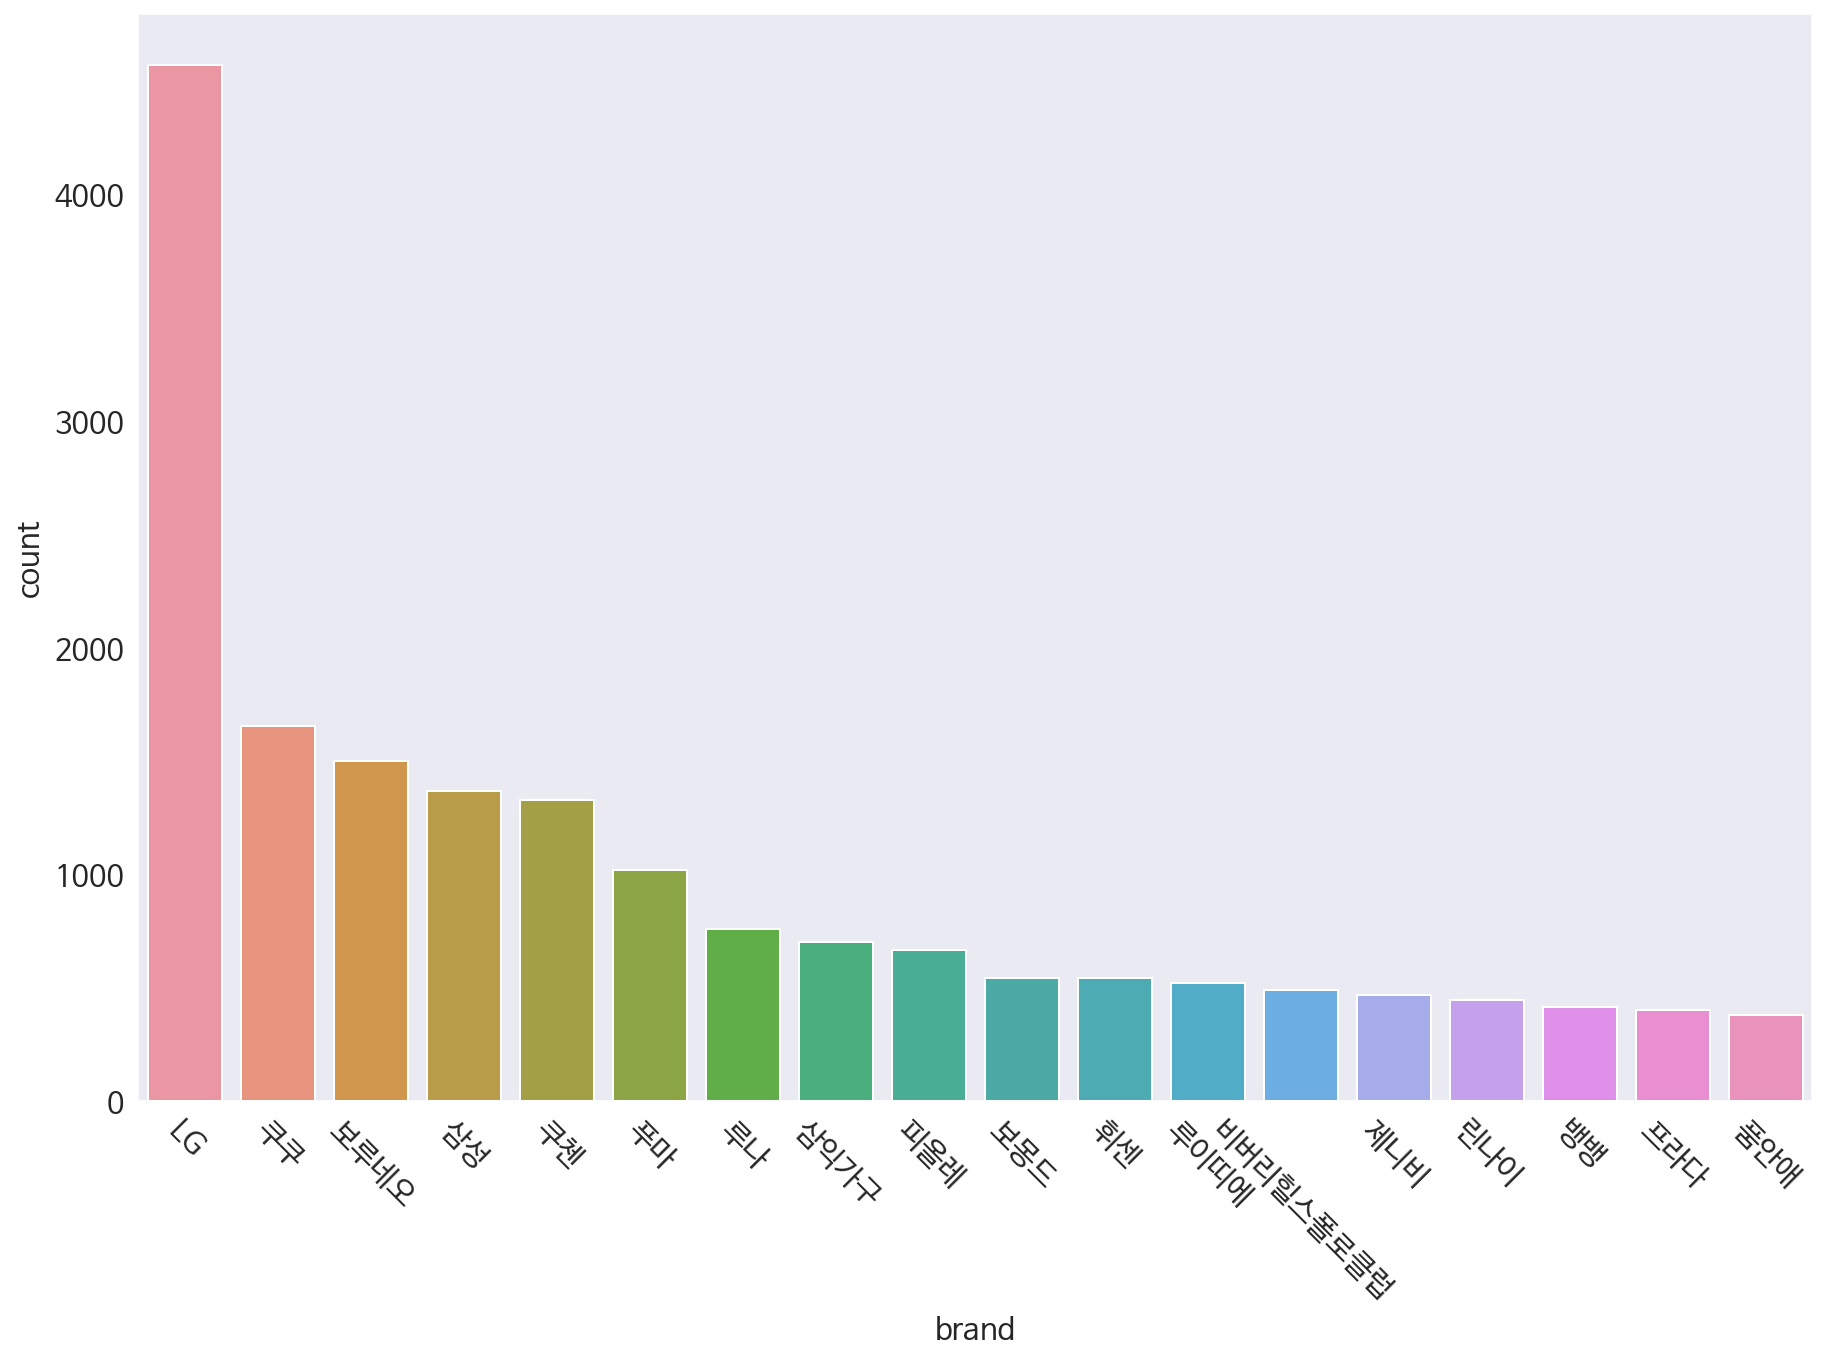

In [ ]:
sns.set_style('dark')


# load the font properties
# 기본 글꼴 변경
fm._rebuild()
plt.rc('font', family='NanumBarunGothic', size = 15)
plt.figure(figsize = (15,10))
plt.xticks(rotation = - 45 )
sns.barplot(data = brand_count, x = 'brand', y = 'count' )

In [ ]:
Pgroup_Pname = pd.read_csv("Pgroup_Pname.csv", encoding = 'utf-8', quotechar= '"')
text = Pgroup_Pname.groupby('상품군').apply(lambda x: textPaste(x['상품명']))

for i in np.arange(text.shape[0]):
  plt.rc('font', family='NanumBarunGothic', size = 15)
  plt.figure(figsize=(20, 17))
  plt.title(text.index[i])
  plt.imshow(WordCloud(font_path = '/content/gdrive/Shared drives/2020 빅콘테스트/malgun.ttf', max_font_size = 100, background_color='white').generate(text.iloc[i]), interpolation='bilinear')
  plt.axis('off')
  

# 출처: https://khann.tistory.com/60 [khann's IT와 경제 블로그]

Output hidden; open in https://colab.research.google.com to view.

# alpha

In [ ]:
alpha = pd.read_csv("alpha.csv", encoding = 'utf-8', quotechar= '"')
alpha_c = pd.read_csv("alpha_c.csv", encoding = 'utf-8', quotechar= '"')
alpha_n = pd.read_csv("alpha_n.csv", encoding = 'utf-8', quotechar= '"')

alpha.index = alpha['Unnamed: 0'].values
alpha = alpha.drop('Unnamed: 0',1)
alpha_c.index = alpha_c['Unnamed: 0'].values
alpha_c = alpha_c.drop('Unnamed: 0',1)
alpha_n.index = alpha_n['Unnamed: 0'].values
alpha_n = alpha_n.drop('Unnamed: 0',1)


alpha_c['Mcode'] = alpha_c['Mcode'].astype('category')
alpha_c['Pcode'] = alpha_c['Pcode'].apply(str).astype('category')
alpha_c['weekday'] = alpha_c['weekday'].astype('category')
alpha_c['holiday'] = alpha_c['holiday'].astype('category')
alpha_c['Pgroup'] = alpha_c['Pgroup'].astype('category')
alpha_c['time'] = alpha_c['time'].apply(str).astype('category')
alpha_c['month'] = alpha_c['month'].astype('category')
alpha_c['number'] = alpha_c['number'].astype('category')
alpha_c['charge'] = alpha_c['charge'].astype('category')
alpha_c['brand'] = alpha_c['brand'].astype('category')
alpha_c['Pg_br'] = alpha_c['Pg_br'].astype('category')
alpha_c['Mc_br'] = alpha_c['Mc_br'].astype('category')
alpha_c['gender'] = alpha_c['gender'].astype('category')


# training test split
# dummy
X, y = alpha[alpha.columns[alpha.columns != 'y']], alpha['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_r, X_test_r, y_train_r, y_test_r = X_train.drop('rating', axis=1), X_test.drop('rating', axis=1), X_train['rating'], X_test['rating']
X_r, y_r = X.drop('rating', axis = 1), X['rating']



# categorical
X_c, y_c = alpha_c[alpha_c.columns[alpha_c.columns != 'y']], alpha_c['y']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=123)
X_train_r_c, X_test_r_c, y_train_r_c, y_test_r_c = X_train_c.drop('rating', axis=1), X_test_c.drop('rating', axis=1), X_train_c['rating'], X_test_c['rating']
X_r_c, y_r_c = X_c.drop('rating', axis = 1), X_c['rating']


# normalized
X_n, y_n = alpha_n[alpha_n.columns[alpha_n.columns != 'y']], alpha_n['y']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=123)
X_train_r_n, X_test_r_n, y_train_r_n, y_test_r_n = X_train_n.drop('rating', axis=1), X_test_n.drop('rating', axis=1), X_train_n['rating'], X_test_n['rating']
X_r_n, y_r_n = X_n.drop('rating', axis = 1), X_n['rating']


train_ds = lgb.Dataset(X_train_c, label = y_train_c) 
test_ds = lgb.Dataset(X_test_c, label = y_test_c)

train_ds_r = lgb.Dataset(X_train_r_c, label = y_train_r_c) 
test_ds_r = lgb.Dataset(X_test_r_c, label = y_test_r_c)


#np.save('y_test',y_test)
#np.save('y_test_r',y_test_r)

In [ ]:
X

,exposure,cost,holiday,rating,package,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y,Pcode_200071,Pcode_200149,Pcode_200150,Pcode_200489,Pcode_200556,Pcode_200612,Pcode_200613,...,Pg_생활용품Na_beauty_y,Pg_속옷Na_beauty_y,Pg_의류Na_beauty_y,Pg_이미용Na_beauty_y,Pg_잡화Na_beauty_y,Pg_주방Na_beauty_y,Pg_침구Na_beauty_y,Pg_가구Na_general_goods_y,Pg_가전Na_general_goods_y,Pg_건강기능Na_general_goods_y,Pg_농수축Na_general_goods_y,Pg_생활용품Na_general_goods_y,Pg_속옷Na_general_goods_y,Pg_의류Na_general_goods_y,Pg_이미용Na_general_goods_y,Pg_잡화Na_general_goods_y,Pg_주방Na_general_goods_y,Pg_침구Na_general_goods_y,Pg_가구Na_kitchen_y,Pg_가전Na_kitchen_y,Pg_건강기능Na_kitchen_y,Pg_농수축Na_kitchen_y,Pg_생활용품Na_kitchen_y,Pg_속옷Na_kitchen_y,Pg_의류Na_kitchen_y,Pg_이미용Na_kitchen_y,Pg_잡화Na_kitchen_y,Pg_주방Na_kitchen_y,Pg_침구Na_kitchen_y,Pg_가구Na_bed_y,Pg_가전Na_bed_y,Pg_건강기능Na_bed_y,Pg_농수축Na_bed_y,Pg_생활용품Na_bed_y,Pg_속옷Na_bed_y,Pg_의류Na_bed_y,Pg_이미용Na_bed_y,Pg_잡화Na_bed_y,Pg_주방Na_bed_y,Pg_침구Na_bed_y
0,20.0,39900.0,1,0.000,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,0,...,0.0,0.0,43.86712,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.36562,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.07235,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8621,0.0,0.0,0.00000,0.0
1,20.0,39900.0,1,0.000,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,0,...,0.0,0.0,43.86712,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.36562,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.07235,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8621,0.0,0.0,0.00000,0.0
2,20.0,39900.0,1,0.000,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,0,...,0.0,0.0,43.86712,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.36562,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.07235,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8621,0.0,0.0,0.00000,0.0
3,20.0,39900.0,1,0.000,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,0,...,0.0,0.0,43.86712,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.36562,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.07235,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8621,0.0,0.0,0.00000,0.0
4,20.0,39900.0,1,0.000,0,-7.9,0.0,1.3,60.0,0.0,4.0,57.93594,62.21644,87.12871,44.99089,46.56390,50.65281,61.54998,40.45996,62.40015,51.93798,58.15949,47.20737,60.16655,73.11881,53.36976,41.15056,43.80495,48.22163,43.86712,51.36562,56.07235,47.86210,0,0,0,0,0,0,0,...,0.0,0.0,43.86712,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.36562,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.07235,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8621,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,20.0,148000.0,0,0.000,0,-7.4,0.0,0.0,45.0,0.0,9.0,47.78399,61.97151,75.74257,60.83788,40.79273,47.16227,50.87982,52.98126,56.08412,42.11886,48.76461,57.43928,65.70578,48.56435,67.

# Modeling & Assessment for 'y'

In [ ]:
# LGBM
# 튜닝한거임
params = {'learning_rate': 0.05, 
          'max_depth': 32, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 128, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

lgb_model = lgb.train(params, train_ds, 1000, test_ds, 
                  verbose_eval=100, early_stopping_rounds=100)
preds_lgb = lgb_model.predict(X_test_c)

# 코드 출처
# http://machinelearningkorea.com/2019/05/18/lightgbm%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%9A%8C%EA%B7%80%EC%98%88%EC%B8%A1-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%B9%98%ED%8A%B8%EC%BD%94%EB%93%9C/

# rmse for LGBM
rmse_lgb = math.sqrt(mean_squared_error(y_test_c, preds_lgb))



# DNN modeling
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
dnn_model = keras.models.Sequential()
dnn_model.add(keras.layers.Dense(512, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(16, activation='relu'))
dnn_model.add(keras.layers.Dense(1))
dnn_model.compile(loss='mape',
            optimizer=opt,
            metrics=['mae', 'mse', 'mape'])

dnn_model.fit(X_train_n, y_train, epochs=20)
dnn_model.summary()

# DNN preds
val_loss, val_mae, val_mse, mape_dnn = dnn_model.evaluate(X_test_n, y_test)
print(mape_dnn)
preds_dnn = dnn_model.predict(X_test_n)
rmse_dnn = math.sqrt(val_mse)




# enssemble
preds_temp = pd.concat([pd.DataFrame(preds_lgb),
                        pd.DataFrame(preds_dnn)], axis = 1)
preds_temp.columns = ['lgb',
                      'dnn']

mape_lgb = np.mean(abs(y_test - preds_lgb)/y_test)
mape_dnn = np.mean(abs(y_test - preds_dnn.reshape(7474))/y_test)


preds_weight_temp = [1/mape_lgb, 
                     1/mape_dnn]

preds_en = preds_temp.apply(lambda x: np.average(x), axis = 1)
preds_Wen = preds_temp.apply(lambda x: np.average(x, weights = preds_weight_temp), axis = 1)

rmse_en = math.sqrt(mean_squared_error(y_test, preds_en))
rmse_Wen = math.sqrt(mean_squared_error(y_test, preds_Wen))


preds_Wen_i = preds_Wen
preds_Wen_i.index = y_test.index
mape_Wen = np.mean(abs(y_test - preds_Wen_i)/y_test)

preds_en_i = preds_en
preds_en_i.index = y_test.index
mape_en = np.mean(abs(y_test - preds_en_i)/y_test)



# test_RMSE for each model
print('==============================================================')
print('RMSE of LGBM     :', rmse_lgb)
print('RMSE of DNN      :', rmse_dnn)
print('RMSE of ENSSEMBLE:', rmse_en)
print('RMSE of W_En     :', rmse_Wen)
print('==============================================================')
print('MAPE of LGBM     :', mape_lgb)
print('MAPE of DNN      :', mape_dnn)
print('MAPE of ENSSEMBLE:', mape_en)
print('MAPE of W_En     :', mape_Wen)



#np.save('preds_lgb',preds_lgb)
#np.save('preds_dnn',preds_dnn)
#np.save('preds_en',preds_en)
#np.save('preds_Wen',preds_Wen)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.724068
[200]	valid_0's mape: 0.637193
[300]	valid_0's mape: 0.6088
[400]	valid_0's mape: 0.594171
[500]	valid_0's mape: 0.584935
[600]	valid_0's mape: 0.57995
[700]	valid_0's mape: 0.57613
[800]	valid_0's mape: 0.574671
[900]	valid_0's mape: 0.572011
[1000]	valid_0's mape: 0.570902
Did not meet early stopping. Best iteration is:
[967]	valid_0's mape: 0.569299
Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

935/935 [==============================] - 4s 4m

# Modeling & Assessment for 'Ratings'

In [ ]:
# LGBM
# 튜닝한거임
params_r = {'learning_rate': 0.01,
          'max_depth': 32,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'mse',
          'is_training_metric': True,
          'num_leaves': 128,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'seed':2018}

lgb_model_r = lgb.train(params_r, train_ds_r, 1000, test_ds_r, verbose_eval=100, early_stopping_rounds=100)
preds_lgb_r = lgb_model_r.predict(X_test_r_c)
rmse_lgb_r = math.sqrt(mean_squared_error(y_test_r_c, preds_lgb_r))



# DNN
# DNN modeling
opt_r = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-7)
dnn_model_r = keras.models.Sequential()
dnn_model_r.add(keras.layers.Dense(512, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(256, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(256, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(128, activation='relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(64, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(32, activation='relu'))
dnn_model_r.add(keras.layers.Dense(16, activation='relu'))
dnn_model_r.add(keras.layers.Dense(1))
dnn_model_r.compile(loss='mse',
            optimizer=opt_r,
            metrics=['mae', 'mse'])

dnn_model_r.fit(X_train_r_n, y_train_r, epochs=20)
dnn_model_r.summary()

# DNN preds
val_loss_r, val_mae_r, val_mse_r = dnn_model_r.evaluate(X_test_r_n, y_test_r)
preds_dnn_r = dnn_model_r.predict(X_test_r_n)
rmse_dnn_r = math.sqrt(val_mse_r)

# CatBoost
cat_model_r = CatBoostRegressor(loss_function='RMSE',
                                eval_metric = 'MAPE',
                                depth=10,
                                learning_rate=0.1,
                                verbose=False,
                                iterations=1000)
cat_model_r.fit(X_train_r, y_train_r)
preds_cat_r = cat_model_r.predict(X_test_r)
mape_cat_r = np.mean(abs(y_test_r-preds_cat_r)/y_test_r)
rmse_cat_r = np.sqrt(mean_squared_error(y_test_r,preds_cat_r))



# enssemble 이건 밑에도 있음 왜냐면 아직 덜 만졌으니까.
preds_temp_r = pd.concat([pd.DataFrame(preds_lgb_r),
                          pd.DataFrame(preds_cat_r),
                          pd.DataFrame(preds_dnn_r)], axis = 1)
preds_temp_r.columns = ['lgb_r',
                        #'xgb_r',
                        'cat_r',
                        #'rf_r',
                        'dnn_r']


preds_weight_temp_r = [1/rmse_lgb_r,
                       1/rmse_cat_r,
                       1/rmse_dnn_r]

preds_en_r = preds_temp_r.apply(lambda x: np.average(x), axis = 1)
preds_Wen_r = preds_temp_r.apply(lambda x: np.average(x, weights = preds_weight_temp_r), axis = 1)

rmse_en_r = math.sqrt(mean_squared_error(y_test_r, preds_en_r))
rmse_Wen_r = math.sqrt(mean_squared_error(y_test_r, preds_Wen_r))


# test_RMSE for each model
print('==============================================================')
print('RMSE of LGBM_r     :', rmse_lgb_r)
print('RMSE of CAT_r      :', rmse_cat_r)
print('RMSE of DNN_r      :', rmse_dnn_r)
print('RMSE of ENSSEMBLE_r:', rmse_en_r)
print('RMSE of WEn_r     :', rmse_Wen_r)


#np.save('preds_lgb_r',preds_lgb_r)
#np.save('preds_cat_r',preds_cat_r)
#np.save('preds_dnn_r',preds_dnn_r)
#np.save('preds_en_r',preds_en_r)
#np.save('preds_Wen_r',preds_Wen_r)
 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000345718
[200]	valid_0's l2: 0.000316953
[300]	valid_0's l2: 0.000303176
[400]	valid_0's l2: 0.000294044
[500]	valid_0's l2: 0.000286337
[600]	valid_0's l2: 0.00027893
[700]	valid_0's l2: 0.000274087
[800]	valid_0's l2: 0.000269107
[900]	valid_0's l2: 0.000264221
[1000]	valid_0's l2: 0.000259786
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.000259786
Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

935/935 [========================

# Rating test

In [ ]:
# rating test
y_test_ad = preds_Wen_r.copy()
y_test_ad.index = y_test.index.copy()
X_test_ad = X_test.copy()
X_test_ad['rating'] = y_test_ad.copy()
X_test_ad_c = X_test_c.copy()
X_test_ad_c['rating'] = y_test_ad.copy()
X_test_ad_n = X_test_n.copy()
X_test_ad_n['rating'] = y_test_ad.copy()

preds_lgb_ad = lgb_model.predict(X_test_ad_c)
preds_dnn_ad = dnn_model.predict(X_test_ad_n)

rmse_lgb_ad = math.sqrt(mean_squared_error(y_test, preds_lgb_ad))
val_loss_ad, val_mae_ad, val_mse_ad, mape_dnn_ad = dnn_model.evaluate(X_test_ad_n, y_test)
rmse_dnn_ad = math.sqrt(val_mse_ad)


# enssemble of rating test
preds_temp_ad = pd.concat([pd.DataFrame(preds_lgb_ad),
                           pd.DataFrame(preds_dnn_ad)], axis = 1)
preds_temp_ad.columns = ['lgb_ad',
                         #'xgb_ad',
                         'dnn_ad']

mape_lgb_ad = np.mean(abs(y_test - preds_lgb_ad)/y_test)
mape_dnn_ad = np.mean(abs(y_test - preds_dnn_ad.reshape(7474))/y_test)


preds_weight_temp_ad = [1/mape_lgb_ad,
                        1/mape_dnn_ad]

preds_en_ad = preds_temp_ad.apply(lambda x: np.average(x), axis = 1)
preds_Wen_ad = preds_temp_ad.apply(lambda x: np.average(x, weights = preds_weight_temp_ad), axis = 1)

rmse_en_ad = math.sqrt(mean_squared_error(y_test, preds_en_ad))
rmse_Wen_ad = math.sqrt(mean_squared_error(y_test, preds_Wen_ad))


preds_Wen_i_ad = preds_Wen_ad
preds_Wen_i_ad.index = y_test_ad.index
mape_Wen_ad = np.mean(abs(y_test - preds_Wen_i_ad)/y_test)

preds_en_i_ad = preds_en_ad
preds_en_i_ad.index = y_test_ad.index
mape_en_ad = np.mean(abs(y_test - preds_en_i_ad)/y_test)



# test_RMSE for each model
print('==============================================================')
print('RMSE of LGBM_ad     :', rmse_lgb_ad)
print('RMSE of DNN_ad      :', rmse_dnn_ad)
print('RMSE of ENSSEMBLE_ad:', rmse_en_ad)
print('RMSE of W_En_ad     :', rmse_Wen_ad)
print('==============================================================')
print('MAPE of LGBM_ad     :', mape_lgb_ad)
print('MAPE of DNN_ad      :', mape_dnn_ad)
print('MAPE of ENSSEMBLE_ad:', mape_en_ad)
print('MAPE of W_En_ad     :', mape_Wen_ad)


#np.save('preds_lgb_ad',preds_lgb_ad)
#np.save('preds_dnn_ad',preds_dnn_ad)
#np.save('preds_en_ad',preds_en_ad)
#np.save('preds_Wen_ad',preds_Wen_ad)

234/234 [==============================] - 1s 3ms/step - loss: 48.9848 - mae: 10762236.0000 - mse: 282851715055616.0000 - mape: 48.9848
RMSE of LGBM_ad     : 9766879.948777448
RMSE of DNN_ad      : 16818195.95127896
RMSE of ENSSEMBLE_ad: 11707455.463467307
RMSE of W_En_ad     : 12003700.5829661
MAPE of LGBM_ad     : 0.5659252388029914
MAPE of DNN_ad      : 0.4898480371704112
MAPE of ENSSEMBLE_ad: 0.4565920535609188
MAPE of W_En_ad     : 0.454109714736579


# Build result Model

In [ ]:
# LGBM for y
params = {'learning_rate': 0.05, 
          'max_depth': 32, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 128, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

lgb_model = lgb.train(params, train_ds, 1000, test_ds, 
                  verbose_eval=100, early_stopping_rounds=100)

# rating
params_r = {'learning_rate': 0.01,
          'max_depth': 32,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'mse',
          'is_training_metric': True,
          'num_leaves': 128,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'seed':2018}

lgb_model_r = lgb.train(params_r, train_ds_r, 1000, test_ds_r, verbose_eval=100, early_stopping_rounds=100)

# 코드 출처
# http://machinelearningkorea.com/2019/05/18/lightgbm%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%9A%8C%EA%B7%80%EC%98%88%EC%B8%A1-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%B9%98%ED%8A%B8%EC%BD%94%EB%93%9C/





# DNN
# DNN modeling
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
dnn_model = keras.models.Sequential()
dnn_model.add(keras.layers.Dense(512, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.Dropout(0.2))
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(16, activation='relu'))
dnn_model.add(keras.layers.Dense(1))
dnn_model.compile(loss='mape',
            optimizer=opt,
            metrics=['mae', 'mse', 'mape'])

dnn_model.fit(X_n, y, epochs=20)
dnn_model.summary()




# DNN modeling for rating
opt_r = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-7)
dnn_model_r = keras.models.Sequential()
dnn_model_r.add(keras.layers.Dense(512, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(256, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(256, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(128, activation='relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(64, activation = 'relu'))
dnn_model_r.add(keras.layers.Dropout(0.2))
dnn_model_r.add(keras.layers.Dense(32, activation='relu'))
dnn_model_r.add(keras.layers.Dense(16, activation='relu'))
dnn_model_r.add(keras.layers.Dense(1))
dnn_model_r.compile(loss='mse',
            optimizer=opt_r,
            metrics=['mae', 'mse'])

dnn_model_r.fit(X_r_n, y_r, epochs=20)
dnn_model_r.summary()



# CatBoost
cat_model_r = CatBoostRegressor(loss_function='RMSE',
                                eval_metric = 'MAPE',
                                depth=10,
                                learning_rate=0.1,
                                iterations=1000)
cat_model_r.fit(X_r, y_r)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.724068
[200]	valid_0's mape: 0.637193
[300]	valid_0's mape: 0.6088
[400]	valid_0's mape: 0.594171
[500]	valid_0's mape: 0.584935
[600]	valid_0's mape: 0.57995
[700]	valid_0's mape: 0.57613
[800]	valid_0's mape: 0.574671
[900]	valid_0's mape: 0.572011
[1000]	valid_0's mape: 0.570902
Did not meet early stopping. Best iteration is:
[967]	valid_0's mape: 0.569299
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000345718
[200]	valid_0's l2: 0.000316953
[300]	valid_0's l2: 0.000303176
[400]	valid_0's l2: 0.000294044
[500]	valid_0's l2: 0.000286337
[600]	valid_0's l2: 0.00027893
[700]	valid_0's l2: 0.000274087
[800]	valid_0's l2: 0.000269107
[900]	valid_0's l2: 0.000264221
[1000]	valid_0's l2: 0.000259786
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.000259786
Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this wa

In [ ]:
'''
dnn_model_json = dnn_model.to_json()
with open("dnn_model.json", "w") as json_file:
    json_file.write(dnn_model_json)
# serialize weights to HDF5
dnn_model.save_weights("dnn_model.h5")
print("Saved model to disk")
dnn_model_r_json = dnn_model_r.to_json()
with open("dnn_model_r.json", "w") as json_file:
    json_file.write(dnn_model_r_json)
# serialize weights to HDF5
dnn_model_r.save_weights("dnn_model_r.h5")
print("Saved model to disk")

pickle.dump(lgb_model,open('lgb_model','wb'))
pickle.dump(lgb_model_r,open('lgb_model_r','wb'))
pickle.dump(cat_model_r,open('cat_model_r','wb'))
'''

Saved model to disk
Saved model to disk


# Predict



In [ ]:
# load json and create model
json_file = open('dnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnn_model = model_from_json(loaded_model_json)
# load weights into new model
dnn_model.load_weights("dnn_model.h5")
print("Loaded model from disk")


# load json and create model
json_file = open('dnn_model_r.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnn_model_r = model_from_json(loaded_model_json)
# load weights into new model
dnn_model_r.load_weights("dnn_model_r.h5")
print("Loaded model from disk")

lgb_model_r = pickle.load(open('lgb_model_r','rb'))
lgb_model = pickle.load(open('lgb_model','rb'))
cat_model_r = pickle.load(open('cat_model_r','rb'))

Loaded model from disk
Loaded model from disk


In [ ]:
y_test = np.load('y_test.npy')
preds_lgb = np.load('preds_lgb.npy')
preds_dnn = np.load('preds_dnn.npy')
preds_en = np.load('preds_en.npy')
preds_Wen = np.load('preds_Wen.npy')

# enssemble
preds_temp = pd.concat([pd.DataFrame(preds_lgb),
                        pd.DataFrame(preds_dnn)], axis = 1)
preds_temp.columns = ['lgb',
                      'dnn']

mape_lgb = np.mean(abs(y_test - preds_lgb)/y_test)
mape_dnn = np.mean(abs(y_test - preds_dnn.reshape(7474))/y_test)


preds_weight_temp = [1/mape_lgb, 
                     1/mape_dnn]



# test_RMSE for each model
print('==============================================================')
print('MAPE of LGBM     :', mape_lgb)
print('MAPE of DNN      :', mape_dnn)


y_test_r = np.load('y_test_r.npy')
preds_lgb_r = np.load('preds_lgb_r.npy')
preds_cat_r = np.load('preds_cat_r.npy')
preds_dnn_r = np.load('preds_dnn_r.npy')
preds_en_r = np.load('preds_en_r.npy')
preds_Wen_r = np.load('preds_Wen_r.npy')

rmse_lgb_r = math.sqrt(mean_squared_error(y_test_r, preds_lgb_r))
rmse_cat_r = math.sqrt(mean_squared_error(y_test_r, preds_cat_r))
rmse_dnn_r = math.sqrt(mean_squared_error(y_test_r, preds_dnn_r))

# enssemble 이건 밑에도 있음 왜냐면 아직 덜 만졌으니까.
preds_temp_r = pd.concat([pd.DataFrame(preds_lgb_r),
                          pd.DataFrame(preds_cat_r),
                          pd.DataFrame(preds_dnn_r)], axis = 1)
preds_temp_r.columns = ['lgb_r',
                        #'xgb_r',
                        'cat_r',
                        #'rf_r',
                        'dnn_r']


preds_weight_temp_r = [1/rmse_lgb_r,
                       1/rmse_cat_r,
                       1/rmse_dnn_r]

preds_en_r = preds_temp_r.apply(lambda x: np.average(x), axis = 1)
preds_Wen_r = preds_temp_r.apply(lambda x: np.average(x, weights = preds_weight_temp_r), axis = 1)

rmse_en_r = math.sqrt(mean_squared_error(y_test_r, preds_en_r))
rmse_Wen_r = math.sqrt(mean_squared_error(y_test_r, preds_Wen_r))


# test_RMSE for each model
print('==============================================================')
print('RMSE of LGBM_r     :', rmse_lgb_r)
print('RMSE of CAT_r      :', rmse_cat_r)
print('RMSE of DNN_r      :', rmse_dnn_r)
print('RMSE of ENSSEMBLE_r:', rmse_en_r)
print('RMSE of WEn_r     :', rmse_Wen_r)


preds_lgb_ad = np.load('preds_lgb_ad.npy')
preds_dnn_ad = np.load('preds_dnn_ad.npy')
preds_en_ad = np.load('preds_en_ad.npy')
preds_Wen_ad = np.load('preds_Wen_ad.npy')

# enssemble of rating test
preds_temp_ad = pd.concat([pd.DataFrame(preds_lgb_ad),
                           pd.DataFrame(preds_dnn_ad)], axis = 1)
preds_temp_ad.columns = ['lgb_ad',
                         'dnn_ad']

mape_lgb_ad = np.mean(abs(y_test - preds_lgb_ad)/y_test)
mape_dnn_ad = np.mean(abs(y_test - preds_dnn_ad.reshape(7474))/y_test)

mape_lgb_ad = np.mean(abs(y_test - preds_lgb_ad)/y_test)
mape_dnn_ad = np.mean(abs(y_test - preds_dnn_ad.reshape(7474))/y_test)


preds_weight_temp_ad = [1/mape_lgb_ad,
                        1/mape_dnn_ad]

print(preds_weight_temp_ad)

MAPE of LGBM     : 0.569298572080904
MAPE of DNN      : 0.4895889407204677
RMSE of LGBM_r     : 0.01611789230606104
RMSE of CAT_r      : 0.01376316913526281
RMSE of DNN_r      : 0.019790797201745477
RMSE of ENSSEMBLE_r: 0.015583794770105235
RMSE of WEn_r     : 0.015255680885529997
[1.767017852243411, 2.0414494376183705]


In [ ]:
beta = pd.read_csv("beta.csv", encoding = 'utf-8', quotechar= '"')
beta_c = pd.read_csv("beta_c.csv", encoding = 'utf-8', quotechar= '"')
beta_n = pd.read_csv("beta_n.csv", encoding = 'utf-8', quotechar= '"')

beta['Unnamed: 0'] = beta['Unnamed: 0'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace('(','')).apply(lambda x: x.replace(')',''))
temp = pd.concat([pd.DataFrame(beta.apply(lambda x: x['Unnamed: 0'][:19],axis=1)),pd.DataFrame(beta.apply(lambda x: x['Unnamed: 0'][-6:],axis=1))],axis=1)
temp.columns = ['방송일시','상품코드']
beta.index = temp.to_records(index = False)
beta = beta.drop('Unnamed: 0',1)

beta_c['Unnamed: 0'] = beta_c['Unnamed: 0'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace('(','')).apply(lambda x: x.replace(')',''))
temp = pd.concat([pd.DataFrame(beta_c.apply(lambda x: x['Unnamed: 0'][:19],axis=1)),pd.DataFrame(beta_c.apply(lambda x: x['Unnamed: 0'][-6:],axis=1))],axis=1)
temp.columns = ['방송일시','상품코드']
beta_c.index = temp.to_records(index = False)
beta_c = beta_c.drop('Unnamed: 0',1)

beta_n['Unnamed: 0'] = beta_n['Unnamed: 0'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace('(','')).apply(lambda x: x.replace(')',''))
temp = pd.concat([pd.DataFrame(beta_n.apply(lambda x: x['Unnamed: 0'][:19],axis=1)),pd.DataFrame(beta_n.apply(lambda x: x['Unnamed: 0'][-6:],axis=1))],axis=1)
temp.columns = ['방송일시','상품코드']
beta_n.index = temp.to_records(index = False)
beta_n = beta_n.drop('Unnamed: 0',1)


beta_c['Mcode'] = beta_c['Mcode'].astype('category')
beta_c['Pcode'] = beta_c['Pcode'].apply(str).astype('category')
beta_c['weekday'] = beta_c['weekday'].astype('category')
beta_c['holiday'] = beta_c['holiday'].astype('category')
beta_c['Pgroup'] = beta_c['Pgroup'].astype('category')
beta_c['time'] = beta_c['time'].apply(str).astype('category')
beta_c['month'] = beta_c['month'].astype('category')
beta_c['number'] = beta_c['number'].astype('category')
beta_c['charge'] = beta_c['charge'].astype('category')
beta_c['brand'] = beta_c['brand'].astype('category')
beta_c['Pg_br'] = beta_c['Pg_br'].astype('category')
beta_c['Mc_br'] = beta_c['Mc_br'].astype('category')
beta_c['gender'] = beta_c['gender'].astype('category')

beta_X = beta.drop('y',axis=1)
beta_X_n = beta_n.drop('y',axis=1)
beta_X_c = beta_c.drop('y',axis=1)

r_lgb = lgb_model_r.predict(beta_X_c.drop('rating',axis=1))
r_dnn = dnn_model_r.predict(beta_X_n.drop('rating',axis=1))
r_cat = cat_model_r.predict(beta_X.drop('rating',axis=1))

# ensemble Rating
r_temp = pd.concat([pd.DataFrame(r_lgb),
                          pd.DataFrame(r_dnn),
                          pd.DataFrame(r_cat)], axis = 1)
preds_temp_r.columns = ['lgb_r',
                        'cat_r',
                        'dnn_r']
r_Wen = r_temp.apply(lambda x: np.average(x, weights = preds_weight_temp_r), axis = 1)
r_Wen.index = beta_X.index

# allocation rating for predict 'y'
beta_X['rating'] = r_Wen
beta_X_n['rating'] = r_Wen
beta_X_c['rating'] = r_Wen

# Predict y
y_lgb = lgb_model.predict(beta_X_c)
y_dnn = dnn_model.predict(beta_X_n)

# ensemble
y_temp = pd.concat([pd.DataFrame(y_lgb),
                          pd.DataFrame(y_dnn)], axis = 1)
y_temp.columns = ['lgb_y',
                  'dnn_y']

y_Wen = y_temp.apply(lambda x: np.average(x, weights = preds_weight_temp_ad), axis = 1)
y_Wen.index = beta.index
y_Wen


(2020-06-01 06:20:00, 201971)    2.679121e+06
(2020-06-01 06:40:00, 201971)    8.653764e+06
(2020-06-01 07:00:00, 201971)    2.425659e+07
(2020-06-01 07:20:00, 202278)    2.521709e+07
(2020-06-01 07:40:00, 202278)    4.257880e+07
                                     ...     
(2020-07-01 00:10:00, 200273)    2.049326e+07
(2020-07-01 00:10:00, 200272)    1.320822e+07
(2020-07-01 00:10:00, 200274)    1.803453e+07
(2020-07-01 01:20:00, 200875)    9.810501e+06
(2020-07-01 01:40:00, 200875)    1.169617e+07
Length: 2716, dtype: float64

## assessment set

In [ ]:
Essessment =  pd.read_excel("2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx", # write your directory here
                       sheet_name = '6월편성', 
                       header = 1, 
                       dtype = {'방송일시': str, 
                                '노출(분)': float, 
                                '마더코드': str,
                                '상품코드': str,
                                '상품명': str,
                                '상품군': str,
                                '판매단가':float,
                                '취급액':float}, # dictionary type
                       na_values = 'NaN', 
                       thousands = ',')
Essessment.index = Essessment[['방송일시', '상품코드']].to_records(index = False)
Essessment['취급액'] = y_Wen
Essessment

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
"(2020-06-01 06:20:00, 201971)",2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,2.679121e+06
"(2020-06-01 06:40:00, 201971)",2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,8.653764e+06
"(2020-06-01 07:00:00, 201971)",2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,2.425659e+07
"(2020-06-01 07:20:00, 202278)",2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900.0,2.521709e+07
"(2020-06-01 07:40:00, 202278)",2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900.0,4.257880e+07
...,...,...,...,...,...,...,...,...
"(2020-07-01 00:20:00, 201989)",2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0.0,NaN
"(2020-07-01 00:40:00, 201989)",2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0.0,NaN
"(2020-07-01 01:00:00, 201989)",2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0.0,NaN
"(2020-07-01 01:20:00, 200875)",2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900.0,9.810501e+06


In [ ]:
# write!!!!!
'''
Essessment.to_csv('Essessment.csv', index = False, encoding = 'utf-8', quotechar= '"')

Essessment.to_excel('Essessment.xlsx', # directory and file name to write
            sheet_name = 'Sheet1', 
            na_rep = 'NaN', 
            float_format = "%.0f", 
            header = True,
            index = False, 
            startrow = 1, 
            startcol = 0, 
            #engine = 'xlsxwriter', 
            freeze_panes = (2, 0)
            ) 
'''


# 출처: https://rfriend.tistory.com/466 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

# 결과 해석 및 활용 등

## 각 변수의 영향

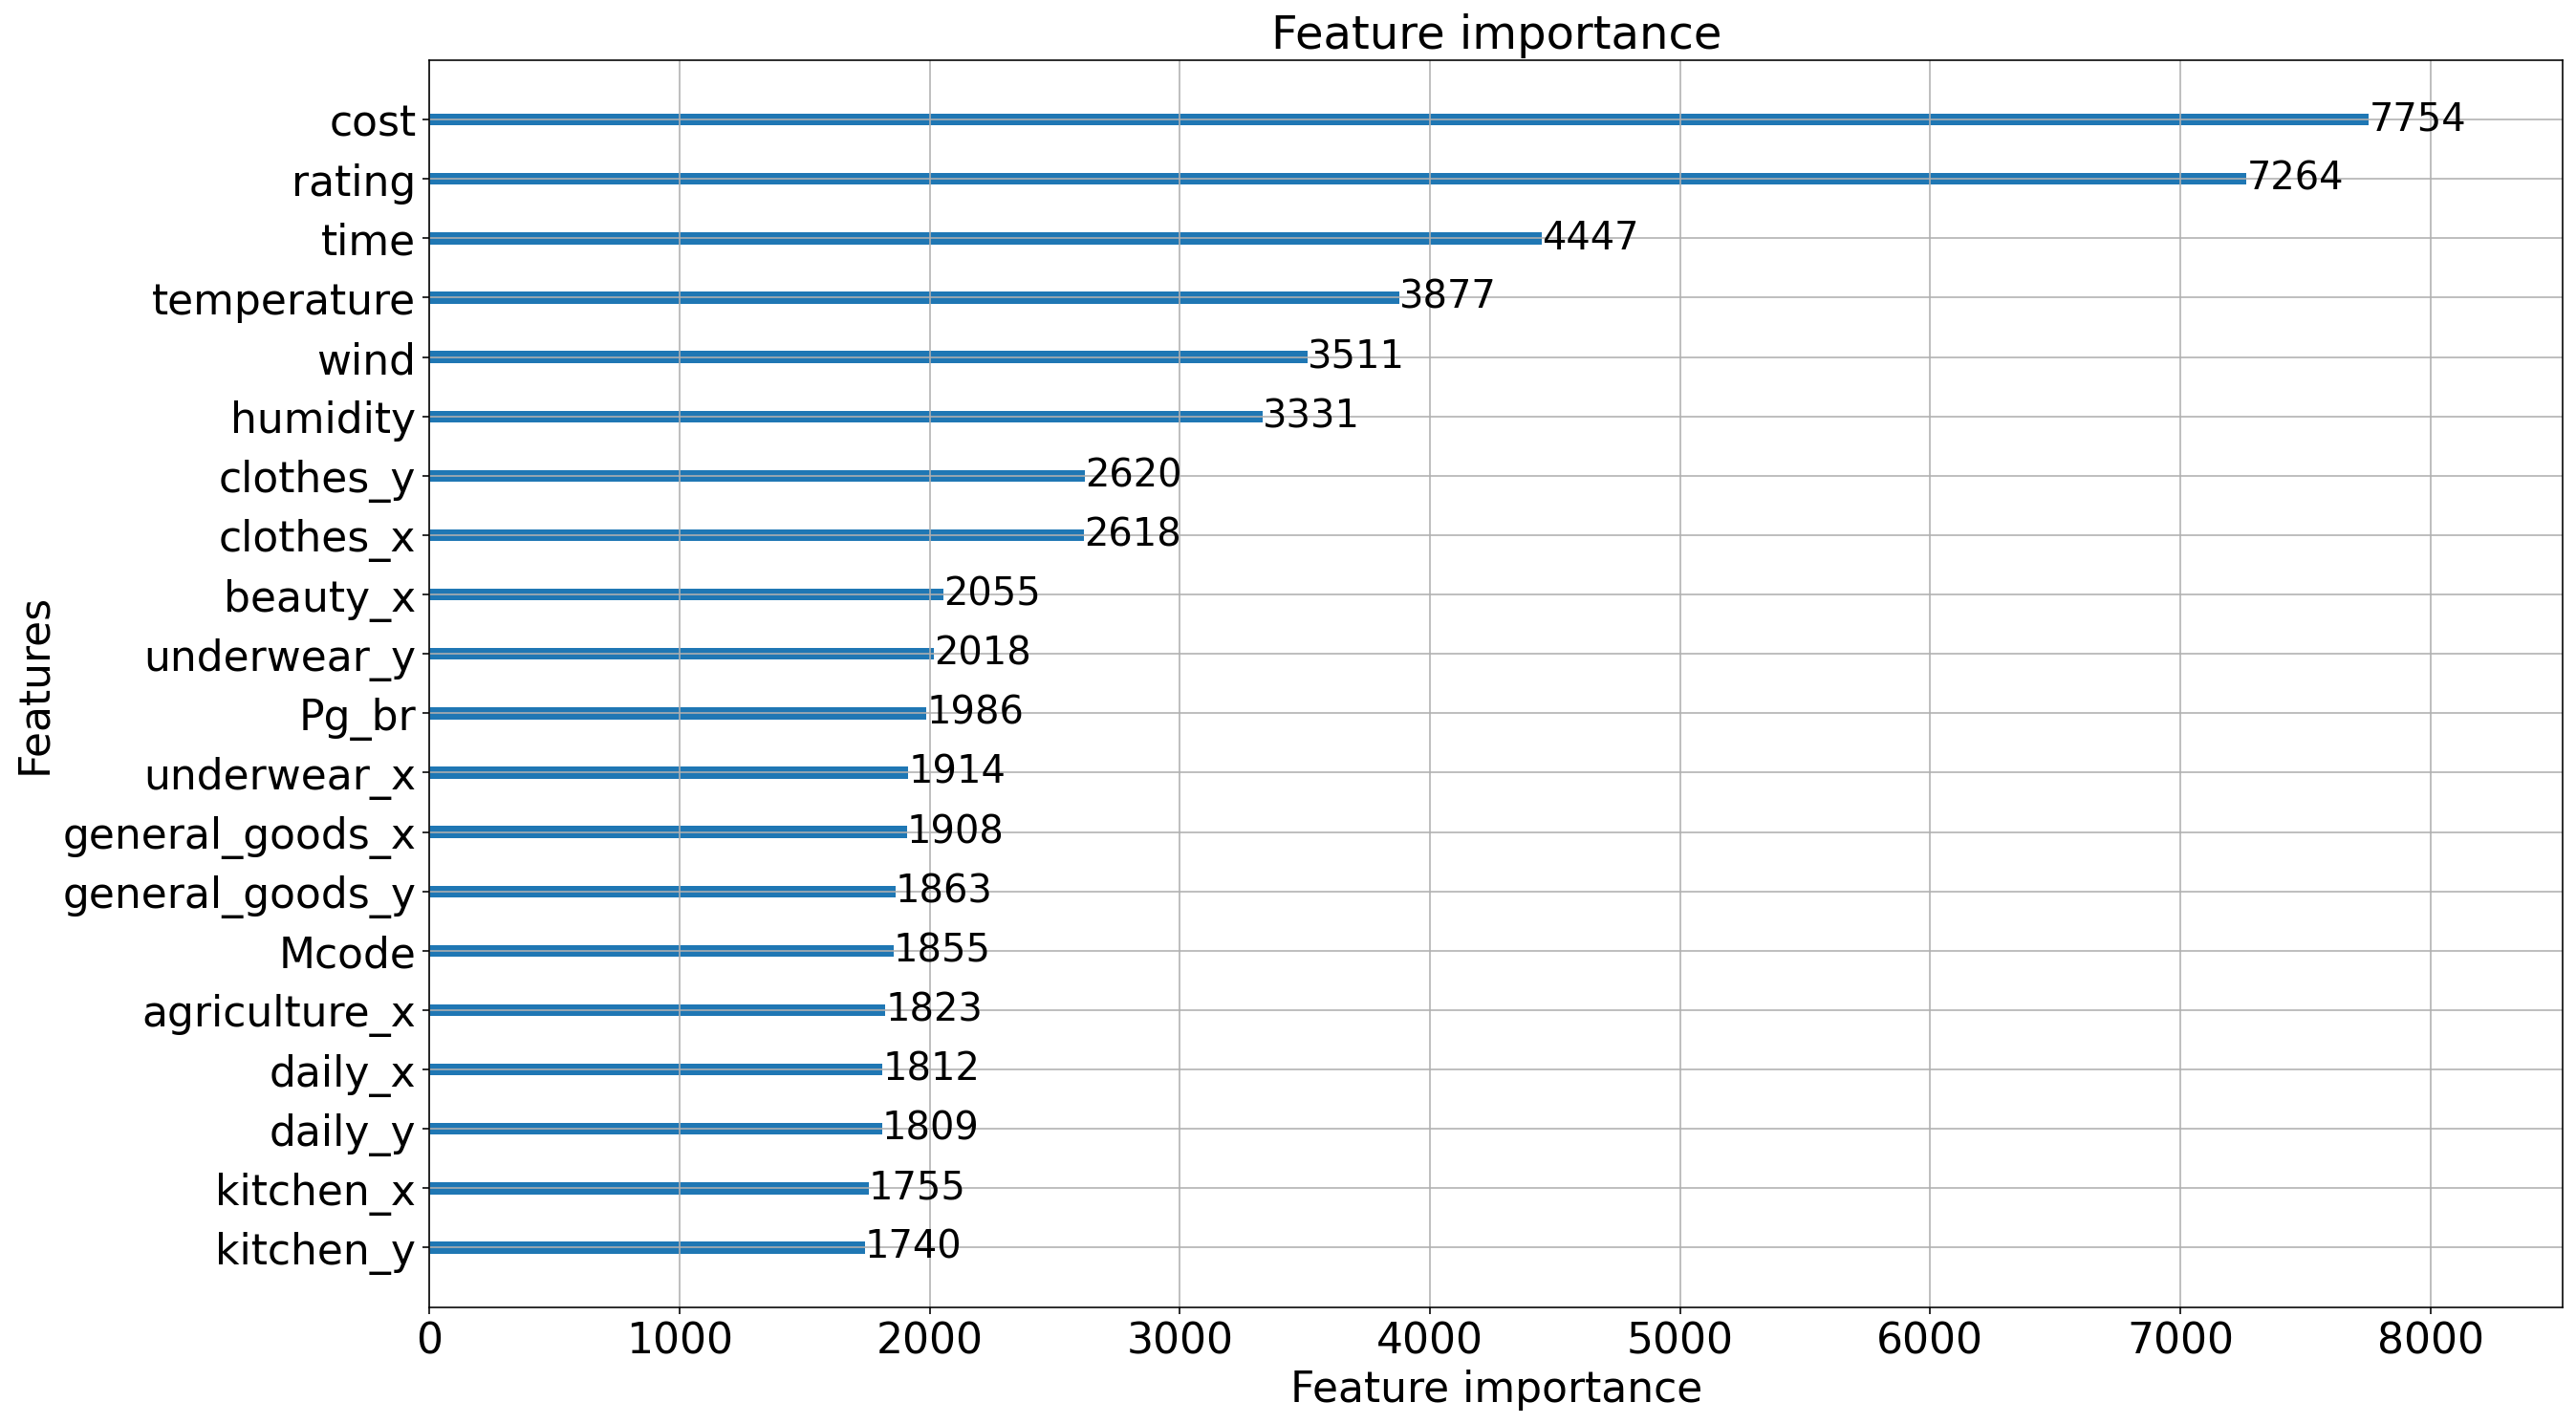

In [ ]:
# plot importance for y
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 20})
lgb.plot_importance(lgb_model,ax=ax, max_num_features = 20)

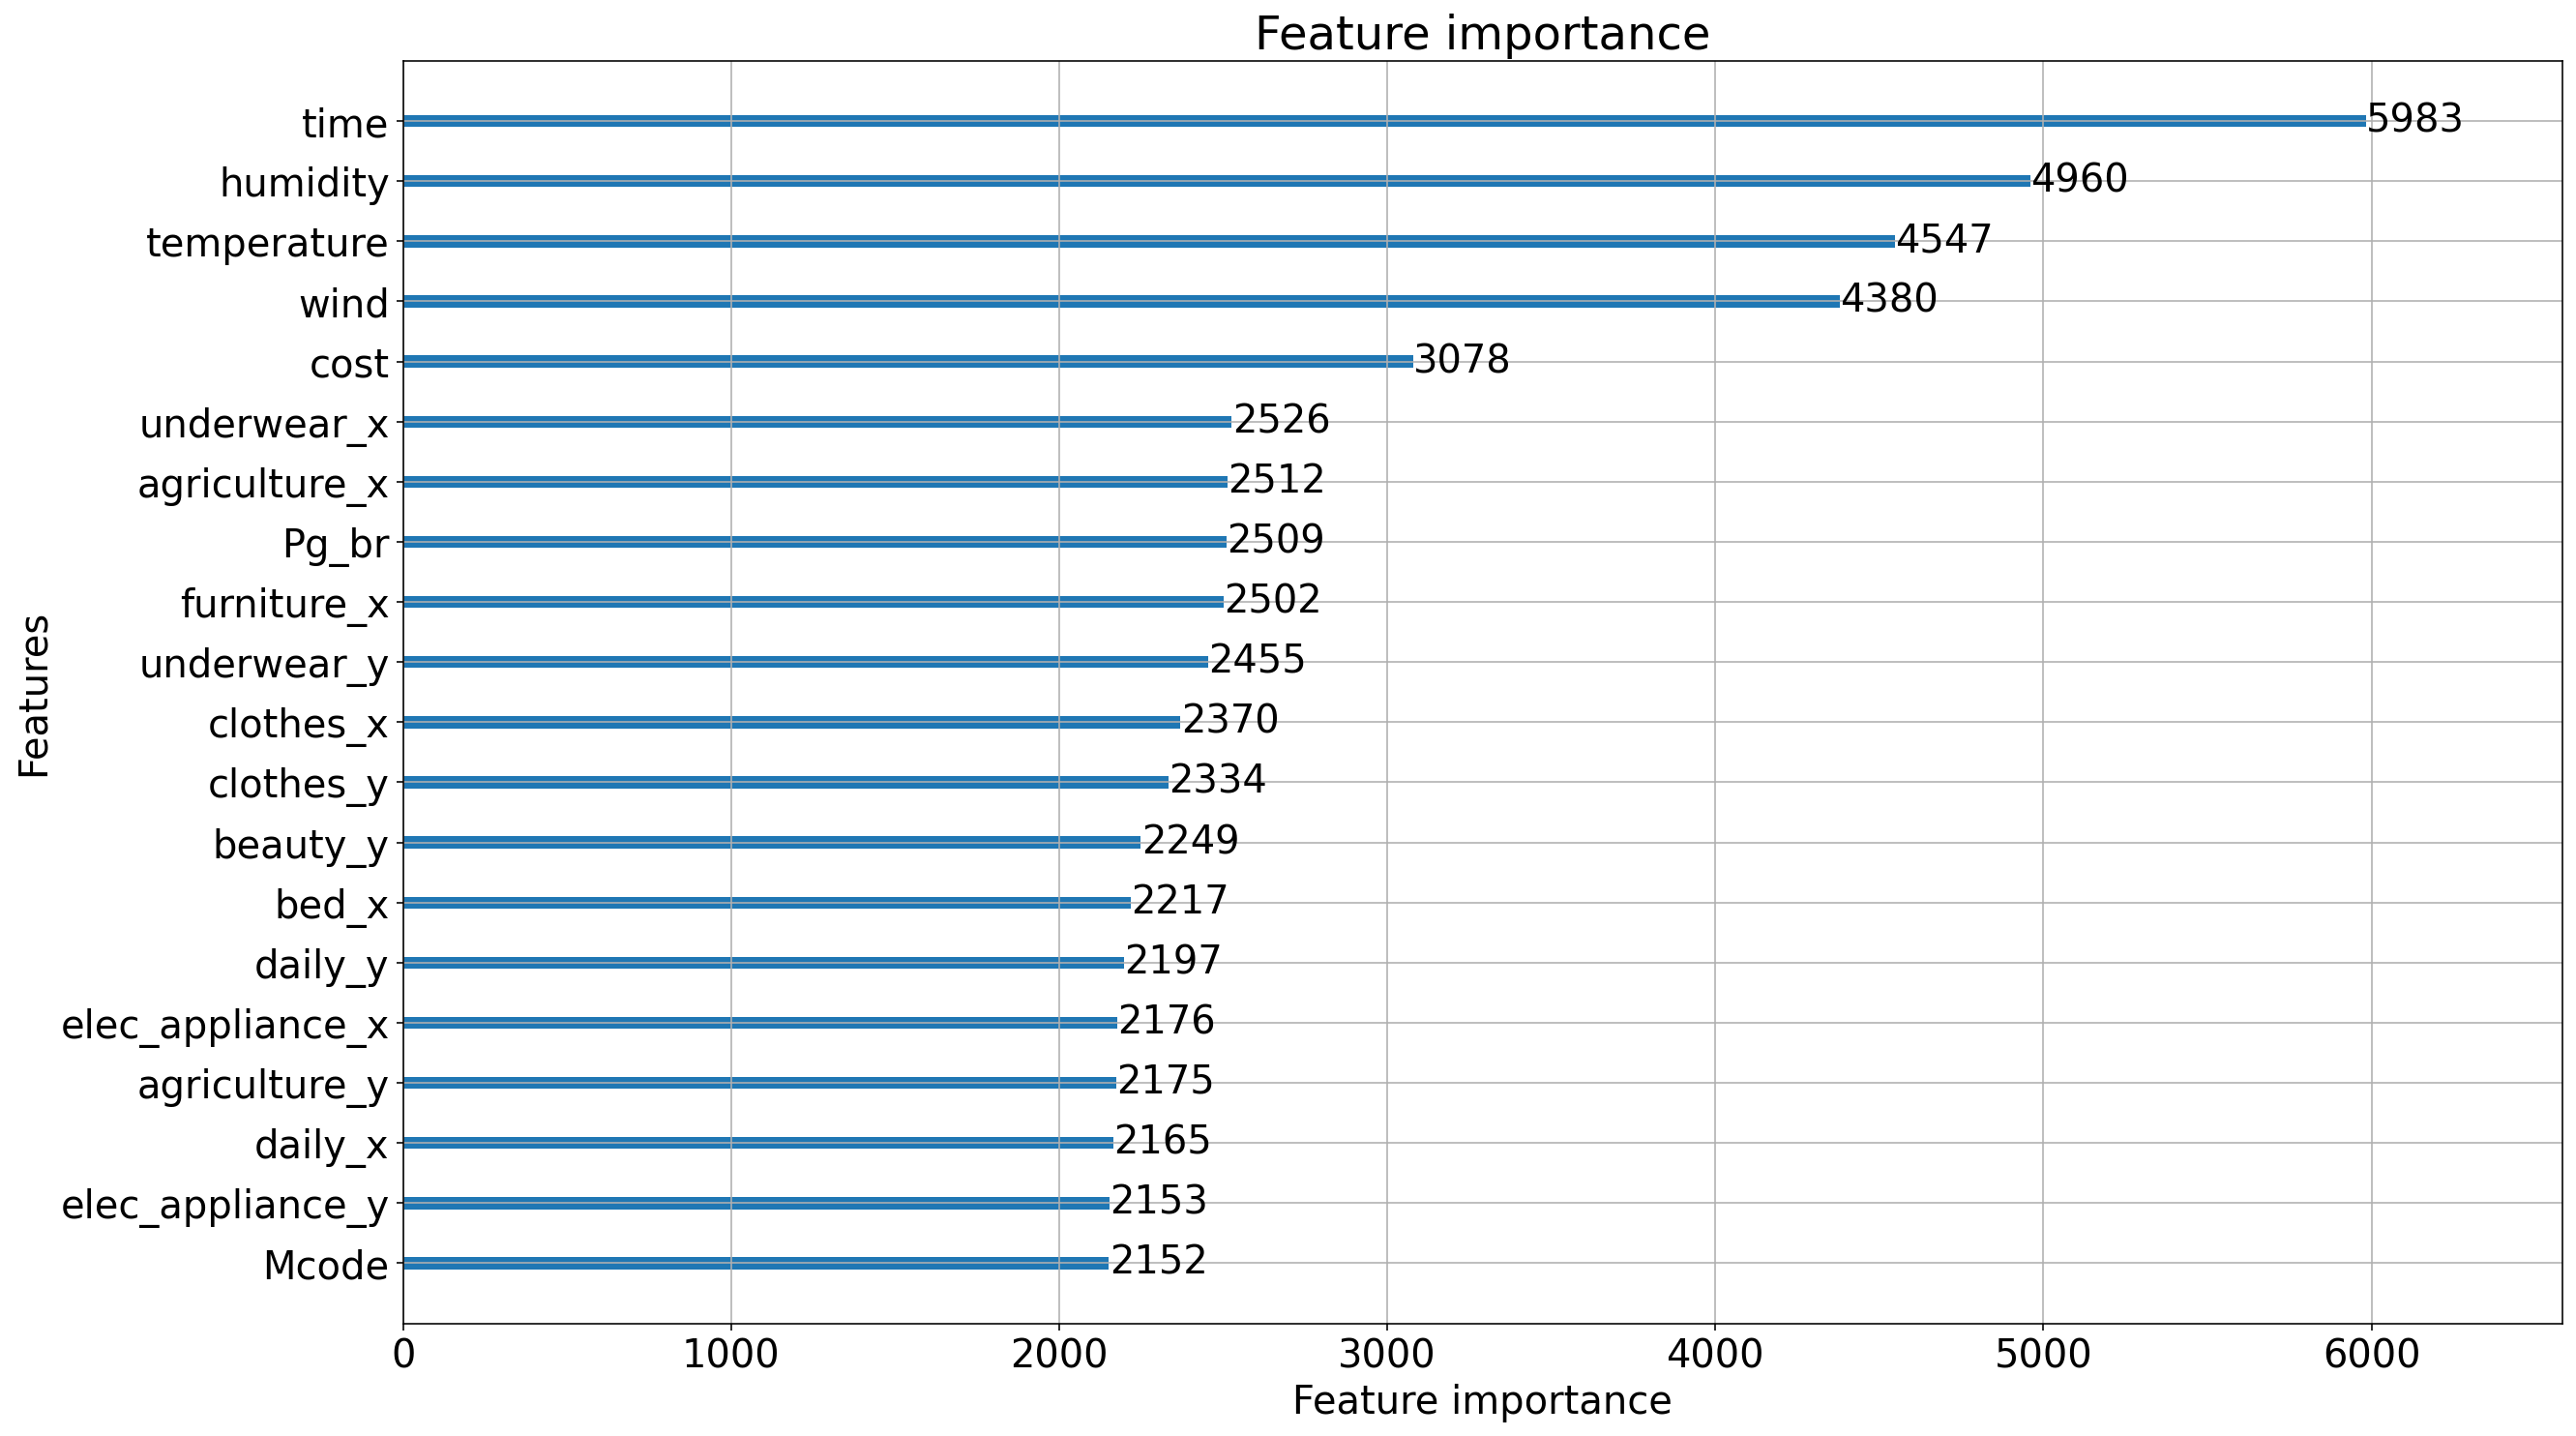

In [ ]:
# plot importance for rating
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 20})
lgb.plot_importance(lgb_model_r,ax=ax, max_num_features = 20)

## Generating 된 데이터 예측


In [ ]:
# load json and create model
json_file = open('dnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnn_model = model_from_json(loaded_model_json)
# load weights into new model
dnn_model.load_weights("dnn_model.h5")
print("Loaded model from disk")


# load json and create model
json_file = open('dnn_model_r.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnn_model_r = model_from_json(loaded_model_json)
# load weights into new model
dnn_model_r.load_weights("dnn_model_r.h5")
print("Loaded model from disk")   

lgb_model_r = pickle.load(open('lgb_model_r','rb'))
lgb_model = pickle.load(open('lgb_model','rb'))
cat_model_r = pickle.load(open('cat_model_r','rb'))

Loaded model from disk
Loaded model from disk


In [ ]:
y_test = np.load('y_test.npy')
preds_lgb = np.load('preds_lgb.npy')
preds_dnn = np.load('preds_dnn.npy')
preds_en = np.load('preds_en.npy')
preds_Wen = np.load('preds_Wen.npy')

# enssemble
preds_temp = pd.concat([pd.DataFrame(preds_lgb),
                        pd.DataFrame(preds_dnn)], axis = 1)
preds_temp.columns = ['lgb',
                      'dnn']

mape_lgb = np.mean(abs(y_test - preds_lgb)/y_test)
mape_dnn = np.mean(abs(y_test - preds_dnn.reshape(7474))/y_test)


preds_weight_temp = [1/mape_lgb, 
                     1/mape_dnn]



# test_RMSE for each model
print('==============================================================')
print('MAPE of LGBM     :', mape_lgb)
print('MAPE of DNN      :', mape_dnn)


y_test_r = np.load('y_test_r.npy')
preds_lgb_r = np.load('preds_lgb_r.npy')
preds_cat_r = np.load('preds_cat_r.npy')
preds_dnn_r = np.load('preds_dnn_r.npy')
preds_en_r = np.load('preds_en_r.npy')
preds_Wen_r = np.load('preds_Wen_r.npy')

rmse_lgb_r = math.sqrt(mean_squared_error(y_test_r, preds_lgb_r))
rmse_cat_r = math.sqrt(mean_squared_error(y_test_r, preds_cat_r))
rmse_dnn_r = math.sqrt(mean_squared_error(y_test_r, preds_dnn_r))

# enssemble 이건 밑에도 있음 왜냐면 아직 덜 만졌으니까.
preds_temp_r = pd.concat([pd.DataFrame(preds_lgb_r),
                          pd.DataFrame(preds_cat_r),
                          pd.DataFrame(preds_dnn_r)], axis = 1)
preds_temp_r.columns = ['lgb_r',
                        #'xgb_r',
                        'cat_r',
                        #'rf_r',
                        'dnn_r']


preds_weight_temp_r = [1/rmse_lgb_r,
                       1/rmse_cat_r,
                       1/rmse_dnn_r]

preds_en_r = preds_temp_r.apply(lambda x: np.average(x), axis = 1)
preds_Wen_r = preds_temp_r.apply(lambda x: np.average(x, weights = preds_weight_temp_r), axis = 1)

rmse_en_r = math.sqrt(mean_squared_error(y_test_r, preds_en_r))
rmse_Wen_r = math.sqrt(mean_squared_error(y_test_r, preds_Wen_r))


# test_RMSE for each model
print('==============================================================')
print('RMSE of LGBM_r     :', rmse_lgb_r)
print('RMSE of CAT_r      :', rmse_cat_r)
print('RMSE of DNN_r      :', rmse_dnn_r)
print('RMSE of ENSSEMBLE_r:', rmse_en_r)
print('RMSE of WEn_r     :', rmse_Wen_r)


preds_lgb_ad = np.load('preds_lgb_ad.npy')
preds_dnn_ad = np.load('preds_dnn_ad.npy')
preds_en_ad = np.load('preds_en_ad.npy')
preds_Wen_ad = np.load('preds_Wen_ad.npy')

# enssemble of rating test
preds_temp_ad = pd.concat([pd.DataFrame(preds_lgb_ad),
                           pd.DataFrame(preds_dnn_ad)], axis = 1)
preds_temp_ad.columns = ['lgb_ad',
                         'dnn_ad']

mape_lgb_ad = np.mean(abs(y_test - preds_lgb_ad)/y_test)
mape_dnn_ad = np.mean(abs(y_test - preds_dnn_ad.reshape(7474))/y_test)

mape_lgb_ad = np.mean(abs(y_test - preds_lgb_ad)/y_test)
mape_dnn_ad = np.mean(abs(y_test - preds_dnn_ad.reshape(7474))/y_test)


preds_weight_temp_ad = [1/mape_lgb_ad,
                        1/mape_dnn_ad]

print(preds_weight_temp_ad)

MAPE of LGBM     : 0.569298572080904
MAPE of DNN      : 0.4895889407204677
RMSE of LGBM_r     : 0.01611789230606104
RMSE of CAT_r      : 0.01376316913526281
RMSE of DNN_r      : 0.019790797201745477
RMSE of ENSSEMBLE_r: 0.015583794770105235
RMSE of WEn_r     : 0.015255680885529997
[1.767017852243411, 2.0414494376183705]


In [ ]:
charlie = pd.read_csv("charlie.csv", encoding = 'utf-8', quotechar= '"')
charlie_c = pd.read_csv("charlie_c.csv", encoding = 'utf-8', quotechar= '"')
charlie_n = pd.read_csv("charlie_n.csv", encoding = 'utf-8', quotechar= '"')

charlie.index = charlie['Unnamed: 0'].values
charlie = charlie.drop('Unnamed: 0',1)
charlie_c.index = charlie_c['Unnamed: 0'].values
charlie_c = charlie_c.drop('Unnamed: 0',1)
charlie_n.index = charlie_n['Unnamed: 0'].values
charlie_n = charlie_n.drop('Unnamed: 0',1)


alpha_c = pd.read_csv("alpha_c.csv", encoding = 'utf-8', quotechar= '"')

alpha_c.index = alpha_c['Unnamed: 0'].values
alpha_c = alpha_c.drop('Unnamed: 0',1)


alpha_c['Mcode'] = alpha_c['Mcode'].astype('category')
alpha_c['Pcode'] = alpha_c['Pcode'].apply(str).astype('category')
alpha_c['weekday'] = alpha_c['weekday'].astype('category')
alpha_c['holiday'] = alpha_c['holiday'].astype('category')
alpha_c['Pgroup'] = alpha_c['Pgroup'].astype('category')
alpha_c['time'] = alpha_c['time'].apply(str).astype('category')
alpha_c['month'] = alpha_c['month'].astype('category')
alpha_c['number'] = alpha_c['number'].astype('category')
alpha_c['charge'] = alpha_c['charge'].astype('category')
alpha_c['brand'] = alpha_c['brand'].astype('category')
alpha_c['Pg_br'] = alpha_c['Pg_br'].astype('category')
alpha_c['Mc_br'] = alpha_c['Mc_br'].astype('category')
alpha_c['gender'] = alpha_c['gender'].astype('category')

charlie_c['Mcode'] = pd.Categorical(charlie_c['Mcode'], categories=list(set(alpha_c['Mcode'])))
charlie_c['Pcode'] = pd.Categorical(charlie_c['Pcode'], categories=list(set(alpha_c['Pcode'])))
charlie_c['weekday'] = pd.Categorical(charlie_c['weekday'], categories=list(set(alpha_c['weekday'])))
charlie_c['holiday'] = pd.Categorical(charlie_c['holiday'], categories=list(set(alpha_c['holiday'])))
charlie_c['Pgroup'] = pd.Categorical(charlie_c['Pgroup'], categories=list(set(alpha_c['Pgroup'])))
charlie_c['time'] = pd.Categorical(charlie_c['time'], categories=list(set(alpha_c['time'])))
charlie_c['month'] = pd.Categorical(charlie_c['month'], categories=list(set(alpha_c['month'])))
charlie_c['number'] = pd.Categorical(charlie_c['number'], categories=list(set(alpha_c['number'])))
charlie_c['charge'] = pd.Categorical(charlie_c['charge'], categories=list(set(alpha_c['charge'])))
charlie_c['brand'] = pd.Categorical(charlie_c['brand'], categories=list(set(alpha_c['brand'])))
charlie_c['Pg_br'] = pd.Categorical(charlie_c['Pg_br'], categories=list(set(alpha_c['Pg_br'])))
charlie_c['Mc_br'] = pd.Categorical(charlie_c['Mc_br'], categories=list(set(alpha_c['Mc_br'])))
charlie_c['gender'] = pd.Categorical(charlie_c['gender'], categories=list(set(alpha_c['gender'])))

In [ ]:
gen_r_lgb = lgb_model_r.predict(charlie_c.drop(['y','rating'],axis=1))
gen_r_dnn = dnn_model_r.predict(charlie_n.drop(['y','rating'],axis=1))
gen_r_cat = cat_model_r.predict(charlie.drop(['y','rating'],axis=1))

# ensemble Rating
gen_r_temp = pd.concat([pd.DataFrame(gen_r_lgb),
                          pd.DataFrame(gen_r_dnn),
                          pd.DataFrame(gen_r_cat)
                          ], axis = 1)
gen_r_temp.columns = ['lgb_r',
                        'cat_r',
                        'dnn_r']
gen_r_Wen = gen_r_temp.apply(lambda x: np.average(x, weights = preds_weight_temp_r), axis = 1)
gen_r_Wen.index = charlie.index

# allocation rating for predict 'y'
charlie['rating'] = gen_r_Wen
charlie_n['rating'] = gen_r_Wen
charlie_c['rating'] = gen_r_Wen

# Predict y
gen_y_lgb = lgb_model.predict(charlie_c.drop('y',axis=1))
gen_y_dnn = dnn_model.predict(charlie_n.drop('y',axis=1))

# ensemble
gen_y_temp = pd.concat([pd.DataFrame(gen_y_lgb),
                          pd.DataFrame(gen_y_dnn)], axis = 1)
gen_y_temp.columns = ['lgb_y',
                  'dnn_y']

gen_y_Wen = gen_y_temp.apply(lambda x: np.average(x, weights = preds_weight_temp_ad), axis = 1)
gen_y_Wen.index = charlie.index
gen_y_Wen

charlie['y'] = gen_y_Wen
charlie.to_csv('generated.csv', index = True, encoding = 'utf-8', quotechar= '"')

In [ ]:
charlie

,y,exposure,cost,holiday,rating,package,temperature,rain,wind,humidity,snow,cloud,furniture_x,elec_appliance_x,health_x,agriculture_x,daily_x,underwear_x,clothes_x,beauty_x,general_goods_x,kitchen_x,bed_x,furniture_y,elec_appliance_y,health_y,agriculture_y,daily_y,underwear_y,clothes_y,beauty_y,general_goods_y,kitchen_y,bed_y,Pcode_200071,Pcode_200149,Pcode_200150,Pcode_200489,Pcode_200556,Pcode_200612,...,Pg_생활용품Na_beauty_y,Pg_속옷Na_beauty_y,Pg_의류Na_beauty_y,Pg_이미용Na_beauty_y,Pg_잡화Na_beauty_y,Pg_주방Na_beauty_y,Pg_침구Na_beauty_y,Pg_가구Na_general_goods_y,Pg_가전Na_general_goods_y,Pg_건강기능Na_general_goods_y,Pg_농수축Na_general_goods_y,Pg_생활용품Na_general_goods_y,Pg_속옷Na_general_goods_y,Pg_의류Na_general_goods_y,Pg_이미용Na_general_goods_y,Pg_잡화Na_general_goods_y,Pg_주방Na_general_goods_y,Pg_침구Na_general_goods_y,Pg_가구Na_kitchen_y,Pg_가전Na_kitchen_y,Pg_건강기능Na_kitchen_y,Pg_농수축Na_kitchen_y,Pg_생활용품Na_kitchen_y,Pg_속옷Na_kitchen_y,Pg_의류Na_kitchen_y,Pg_이미용Na_kitchen_y,Pg_잡화Na_kitchen_y,Pg_주방Na_kitchen_y,Pg_침구Na_kitchen_y,Pg_가구Na_bed_y,Pg_가전Na_bed_y,Pg_건강기능Na_bed_y,Pg_농수축Na_bed_y,Pg_생활용품Na_bed_y,Pg_속옷Na_bed_y,Pg_의류Na_bed_y,Pg_이미용Na_bed_y,Pg_잡화Na_bed_y,Pg_주방Na_bed_y,Pg_침구Na_bed_y
"('202244', 14, '19')",3.107486e+07,20.0,749000.0,1,0.013689,0,24.9,0.0,4.4,66.0,0.0,0.0,77.30544,100.00000,29.55445,61.74863,50.47252,82.76045,69.71171,41.31175,87.00077,65.37467,72.49593,63.66429,92.82915,27.02970,56.28415,42.14148,69.25126,66.49195,43.18568,79.34166,51.67958,62.22814,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,79.34166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,51.67958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,62.22814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
"('202244', 21, '20')",2.865684e+07,20.0,749000.0,1,0.011524,0,28.1,0.0,2.1,53.0,0.0,0.0,73.68576,89.40764,32.22772,66.12021,51.89466,77.85771,66.71658,43.86712,83.20342,67.82945,57.65645,61.00425,79.64051,26.43564,64.84517,40.74685,68.69171,64.09584,39.86371,76.03388,56.97674,46.19026,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,76.03388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,56.97674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,46.19026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
"('202244', 9, '06')",2.759668e+07,20.0,749000.0,0,0.013385,0,20.4,0.0,1.5,73.0,0.0,2.0,59.26175,89.41517,47.67326,80.51001,57.95944,79.16333,67.42792,63.37308,75.90827,74.41860,70.82408,67.71328,92.95726,48.26732,79.59927,59.33571,79.80282,72.25758,66.18398,78.40440,79.32816,71.66740,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,78.40440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,79.32816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,71.66740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
"('202244', 17, '09')",2.950100e+07,20.0,749000.0,0,0.012780,0,24.7,0.0,1.7,58.0,0.0,8.0,54.74557,79.17326,48.51485,69.03460,54.51876,75.91260,72.55709,61.24361,78.52035,66.79586,52.75928,58.82402,84.75016,46.83168,75.95628,56.95017,75.83266,69.41220,56.38841,76.38173,73.77260,59.41707,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,76.38173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,73.77260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,59.41707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
"('202244', 24, '01')",2.288143e+07,20.0,749000.0,0,0.013080,0,26.1,0.0,1.4,64.0,0.0,10.0,59.37539,81.28721,43.71287,69.76320,53.93155,74.76685,75.14039,60.73253,75.68603,71.31782,47.24071,58.70196,84.26784,47.92079,80.87431,56.61069,76.17905,69.82403,58.43270,75.60551,80.10335,52.68530,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,75.60551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,80.10335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,52.68530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('200378', 12, '17')",2.535640e+07

# 최적 편성 (Hungarian Algorithm)

In [ ]:
# 최적 편성
generated = pd.read_csv("generated.csv", encoding = 'utf-8', quotechar= '"')
generated.rename(columns={'Unnamed: 0' : 'by'},inplace=True)

temp = generated['by'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace('(','')).apply(lambda x: x.replace(')','')).apply(lambda x: x.replace(' ','')).str.split(pat = ',', expand = True)
temp.columns = ['Pcode','day','time']

generated['day'] = temp['day']
generated['time'] = temp['time']
generated['Pcode'] = temp['Pcode']


newmat = generated[['y', 'day', 'time', 'Pcode']]
generated = pd.DataFrame()
newmat.index = np.arange(newmat.shape[0])
newmat['group'] = newmat[['day', 'time']].to_records(index = False).tolist()
newmat2 = newmat.drop('day',1).drop('time',1)
#newmat2 # pcode별 group별로 y 평균내버리지 뭐
newmat3 = newmat2.groupby(['Pcode', 'group'],group_keys=False)['y'].mean()
newmat3 = newmat3.reset_index() 
newmat3 = newmat3.pivot(index='Pcode', columns='group', values='y')
newmat3_2 = newmat3.copy()
newmat_index = pd.DataFrame(newmat3.index)
newmat3_2.index = np.array(newmat_index.apply(lambda x: x+'_2')).reshape(-1)
newmat0 = pd.concat([newmat3,newmat3_2],axis=0)
newmat4 = np.array(newmat0)


# profit 계산

m = Munkres()
# matrix = m.pad_matrix(newmat4)
matrix = pad_to_square(newmat4)
cost_matrix = []
for row in matrix:
    cost_row = []
    for col in row:
        cost_row += [sys.maxsize - col]
    cost_matrix += [cost_row]

#m = Munkres()
#indexes = m.compute(cost_matrix)
############# np.save ###################
#np.save('indexes_new.npy', indexes)###
#########################################



In [ ]:
indexes = np.load('indexes_new.npy')

# Hungarian Algorithm
total = 0
Pcode_temp = []
date_temp = []
for row, column in indexes:
    value = matrix[row][column]
    total += value
    #print(f'({row}, {column}) -> {value}')
    if value > 0 :
      Pcode_temp.append(newmat0.index[row])
      date_temp.append(newmat0.columns[column])

result = pd.concat([pd.DataFrame(Pcode_temp), pd.DataFrame(date_temp)],1)
result.columns = ['Pcode','day','time']
#print(f'total profit={total}')
print('Optimized Sales')
print(total*3)
##################################### Result sace ##############################
#result.to_csv('result.csv', index = True, encoding = 'utf-8', quotechar= '"')###
################################################################################

Optimized Sales
78977772659.70233


In [ ]:
result = pd.read_csv("result.csv", encoding = 'utf-8', quotechar= '"')
temp = result[result['day'] > 7]
temp = temp[temp['day'] < 15]
temp = temp[temp['time'] > 13]
temp = temp[temp['time'] < 16]
temp = temp.drop('Unnamed: 0',axis=1)
temp['Pcode'] = temp.apply(lambda x: x['Pcode'].replace('_2',''),axis=1)
temp.pivot(index='time', columns='day', values='Pcode')

day,8,9,10,11,12,13,14
time,,,,,,,
14,200725,201811,202243,200941,200486,202363,200867
15,201269,200368,200551,201595,201728,202391,202037
